# Analysis Script Demo

The purpose of the `Analysis Script` is to automate analysis of `DockStream` run outputs. The analysis includes calculating correlation metrics and generation of enrichment plots. This enables the results from different `DockStream` run configurations to be quantitatively and qualitatively compared. Therefore, the `Analysis Script` is particularly well suited for analyzing the data from batch executions of `DockStream` enabled by the `Benchmarking Script`. A demo for the `Benchmarking Script` can be found in the `demo_Benchmarking_Script` Jupyter notebook. This notebook focuses strictly on the `Analysis Script`. Specifics into the capabilities of the `Analysis Script` are explained in this notebook which is divided into 3 sections to reflect the 3 distinct use cases supported.


# Analysis Script Use Cases:
  1. Enrichment Analysis
  2. Correlation Analysis
  3. Thresholds Analysis 

__Note:__ By default, this notebook will deposit all files created into `~/Desktop/Analysis_demo`.

The following imports / loadings are only necessary when executing this notebook. If you want to use `analysis.py` directly from the command-line, it is enough to execute the following with the appropriate input JSON:

```
conda activate DockStream
python /path/to/DockStream/analysis.py -input_json <path to analysis configuration json>
```

In [1]:
import os
import json
import tempfile
import pandas as pd
import ipykernel

# update these paths to reflect your system's configuration
dockstream_path = os.path.expanduser("~/Desktop/ProjectData/DockStream")
dockstream_env = os.path.expanduser("~/miniconda3/envs/DockStreamCommunity")

# no changes are necessary beyond this point
# ---------
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# generate the path to the analysis script entry point
analysis_script = os.path.join(dockstream_path, "analysis.py")

# generate a folder with 3 subfolders to store the output
output_dir = os.path.expanduser("~/Desktop/Analysis_demo")
enrichment_results_dir = os.path.join(output_dir, "Enrichment_Output")
correlation_results_dir = os.path.join(output_dir, "Correlation_Output")
thresholds_results_dir = os.path.join(output_dir, "Thresholds_Output")
try:
    os.mkdir(output_dir)
    os.mkdir(enrichment_results_dir)
    os.mkdir(correlation_results_dir)
    os.mkdir(thresholds_results_dir)
except FileExistsError:
    pass

# 1. Enrichment Analysis

Suppose you are involved in an early phase project and want to integrate an *in silico* docking component. You do not have any experimental data yet but perhaps there is in-house data or public data that has been compiled into a set of active ligands and inactive ligands (a *calibration dataset*). As a first effort, you are interested in identifying a docking protocol that can "pick out" an active ligand when some arbitrary large number of ligands is docked. In the perfect scenario, active ligands will score much better than inactive ligands (on average) when docked with some combination of backend + ligand embedder + settings. The `Benchmarking Script` was introduced to automate and streamline batch execution of `DockStream`. The `Analysis Script` and specfically its `Enrichment Analysis` functionality was introduced to automate generation of histograms, boxplots, and pROC curves to qualitatively and quantitatively compare enrichment between different `DockStream` runs. The dataset used in this section is from the DEKOIS 2.0 dataset. For more information:

https://pubs.acs.org/doi/abs/10.1021/ci400115b

Cyclooxygenase-2 (COX2) and Glutaminyl-peptide cyclotransferase (QPCT) from the DEKOIS 2.0 dataset were chosen to demonstrate `Enrichment Analysis`. These public datasets provide a set of active and inactive ligands which have been docked using `Glide`. The corresponding `DockStream` outputs were shipped with the `DockStream` codebase and is ready for use in this notebook. Note, `Glide` was chosen as the backend arbitrarily - `Enrichment Analysis` is compatible with any backend. Let's take a look at the COX2 active and inactive ligands `Glide` data.

In [2]:
# generate the paths to the COX2 actives and inactives data shipped with this implementation
COX2_ACTIVES_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/COX2_Glide_Actives.csv")
COX2_INACTIVES_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/COX2_Glide_Inactives.csv")

# read the COX2 actives and inactives data to show its contents
COX2_ACTIVES = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/Active/COX2_Glide_LigPrep.csv"))
COX2_INACTIVES = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/Inactive/COX2_Glide_LigPrep.csv"))

In [3]:
# visualize the COX2 actives data
COX2_ACTIVES.head(3)

,ligand_number,enumeration,conformer_number,name,score,smiles,lowest_conformer
0,0,0,0,0:0:0,-10.5418,[H]c1c([H])c(-c2c(-c3c([H])c([H])c(S(=O)(=O)N(...,True
1,1,0,0,1:0:0,-10.5469,[H]c1c([H])c(-c2c(-c3c([H])c([H])c(S(=O)(=O)C(...,True
2,3,0,0,3:0:0,-10.3447,[H]c1c(-c2c([H])c([H])c(S(=O)(=O)C([H])([H])[H...,True


In [4]:
# visualize the COX2 inactives data
COX2_INACTIVES.head(3)

,ligand_number,enumeration,conformer_number,name,score,smiles,lowest_conformer
0,0,0,0,0:0:0,-6.02393,[H]c1c(Cl)c([H])n2c(Sc3nc(C([H])([H])[H])nc4sc...,True
1,3,1,0,3:1:0,-4.61955,[H]C(c1c(N2C([H])([H])C([H])([H])OC([H])([H])C...,True
2,15,0,0,15:0:0,-4.89755,[H]c1sc(-n2nnn(C([H])([H])C(=O)[N-]c3nc4c([H])...,True


The above cells display the first 3 entries in the COX2 actives and inactives data. The important observation is that the `CSV` files provided are simply the raw and unmodified `DockStream` output `CSVs`.

A quick glance at the data shows that the `Glide` scores for the active ligands are lower (more potent) than the `Glide` scores for the inactive ligands which is desirable. We will now demonstrate the generation of an enrichment histogram and boxplot using the `Analysis Script`. Similar to the `Benchmarking Script`, a configuration `JSON` is required as an input argument. Let's take a look at the `Analysis Script` configuration `JSON` as applied to `Enrichment Analysis`. 

**Note:** All the parameters of the configuration `JSON` will be covered in this notebook but for the purpose of each `Analysis Script` usage section, the relevant parameters will be marked using a comment while non-relevant parameters will have value `"---"`.

In [5]:
enrichment_json = {
  "input_docking_data": {
    "data_path": "---",
    "data_metric": "---",
    "max_data_metric_best": "---",
    "data_thresholds": "---"
  },
  "input_exp_data": {
    "exp_data_path": "---",
    "exp_metric": "---",
    "max_exp_metric_best": "---",
    "exp_thresholds": "---"
  },
  "input_enrichment_data": { 
    "data_path_actives": COX2_ACTIVES_PATH,     # path to the DockStream output for the active ligands
    "data_path_inactives": COX2_INACTIVES_PATH, # path to the DockStream output for the inactive ligands
    "actives_data_metric": "score",             # active ligands activity metric
    "inactives_data_metric": "score",           # inactive ligands activity metric
    "max_metric_best": "False"                  # denotes whether a greater value is better (ex. GOLD GoldScore)
  },
  "plot_settings": {
    "enrichment_analysis": "True",              # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                     # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": enrichment_results_dir       # desired output directory
  }
}

with open(os.path.join(output_dir, "enrichment.json"), "w+") as f:
    json.dump(enrichment_json, f, indent=2)

The relevant parameters for an `Enrichment Analysis` configuration JSON are elaborated below:

* `"data_path_actives" / "data_path_inactives"`

Path to a `CSV` file containing the active/inactive ligands data. This is typically the raw and unmodified `DockStream` output. It is perfectly fine for this `CSV` to be any `CSV` file as long as it contains a column that contains the activity data (e.g. for `DockStream` output, the activity data will be `"score"` which represents the docking score).

* `"actives_data_metric" / "inactives_data_metric"`

String that denotes the name of the activity metric for the active/inactive ligands in their corresponding `CSV` files. Typically, both of these parameters will be `"score"` as the most common use case will be inputting the raw and unmodified `DockStream` output for both active and inactive ligands.

* `"max_metric_best"`

Boolean which denotes whether a greater value is better for the actives / inactive data (e.g. for `Glide` docking scores, the lower the score, the greater the predicted binding affinity - `"max_metric_best"` = "False")

* `"enrichment_analysis"`

Boolean which denotes whether the user wants to perform `Enrichment Analysis`. This parameter takes only 2 possible values: `"True"` or `"False"`. If `"True"`, *only* enrichment histograms, boxplots, and pROC curves are generated. Importantly, this also causes the script to ignore all other parameters in the configuration `JSON` except the ones that are marked in the above code block by a comment. Therefore, it is this boolean parameter that allows executing the `Analysis Script` for `Enrichment Analysis`. If `"False"`, all the parameters marked in the above code block by a comment are ignored and denotes that the `Analysis Script` should perform either `Correlation Analysis` or `Thresholds Analysis` which will be introduced later.

* `"pROC_overlay"`

Boolean which denotes whether the user wants to generate **only** an overlay pROC curve. This parameter is only parsed if "enrichment_analysis" as defined above is set to `"True"`. Enrichment histograms and boxplots are not generated.

* `"output_path"`

Path to the desired output directory. This is where all the output of the `Analysis Script` execution will be saved.

Let's now execute the `Analysis Script` with the configuration `JSON` above.

In [6]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "enrichment.json")}

Enrichment histogram, boxplot, and pROC curve constructed. Exiting script now.


After executing the above cell block, an enrichment histogram, boxplot, and pROC curve is generated and saved into the specified output directory. Let's take a look at these plots.

<div>
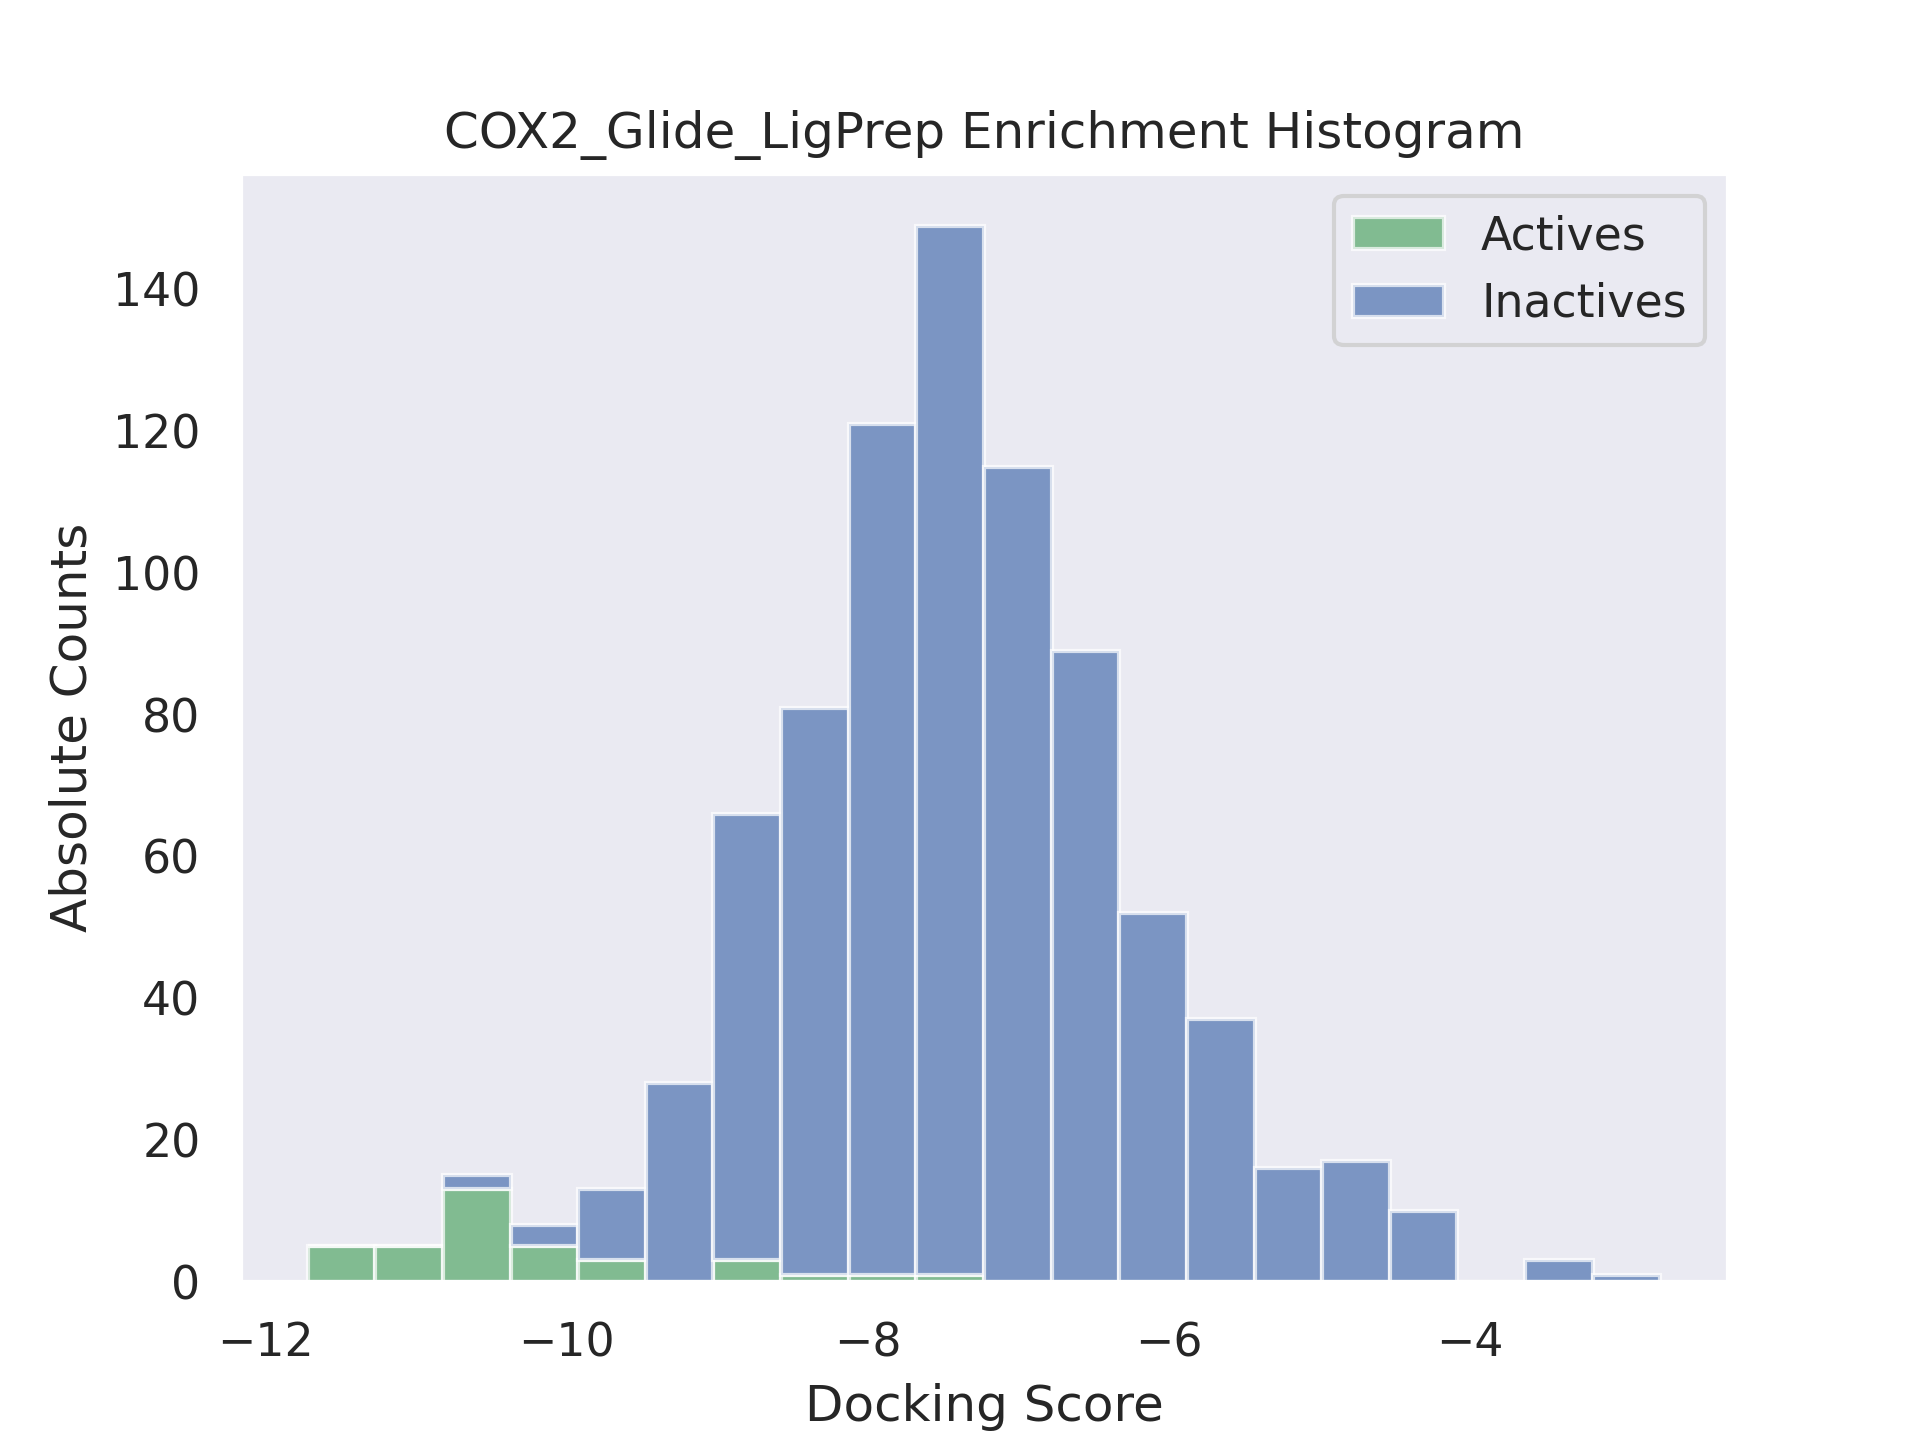
</div>

The enrichment histogram plots the docking scores and the frequency of occurence in each bin for both active and inactive ligands. It is evident that there is enrichment observed as the active ligands generally exhibit a better docking score than the inactive ligands. Therefore, the docking configuration above (`Glide` with `LigPrep` was used in this example) could be well suited for initial *in silico* design efforts for this specific protein target. Unfortunately, there is an imbalance in the dataset with many more inactive ligands than active ligands which is a common occurrence. Consequently, it can be difficult to gain an appreciation for the actual spread of the active ligands' docking scores as the height of some bins can be quite small (ex. the green bins at ~ -8 docking score). In situations like this, an enrichment boxplot can better illustrate enrichment. Let's take a look:

<div>
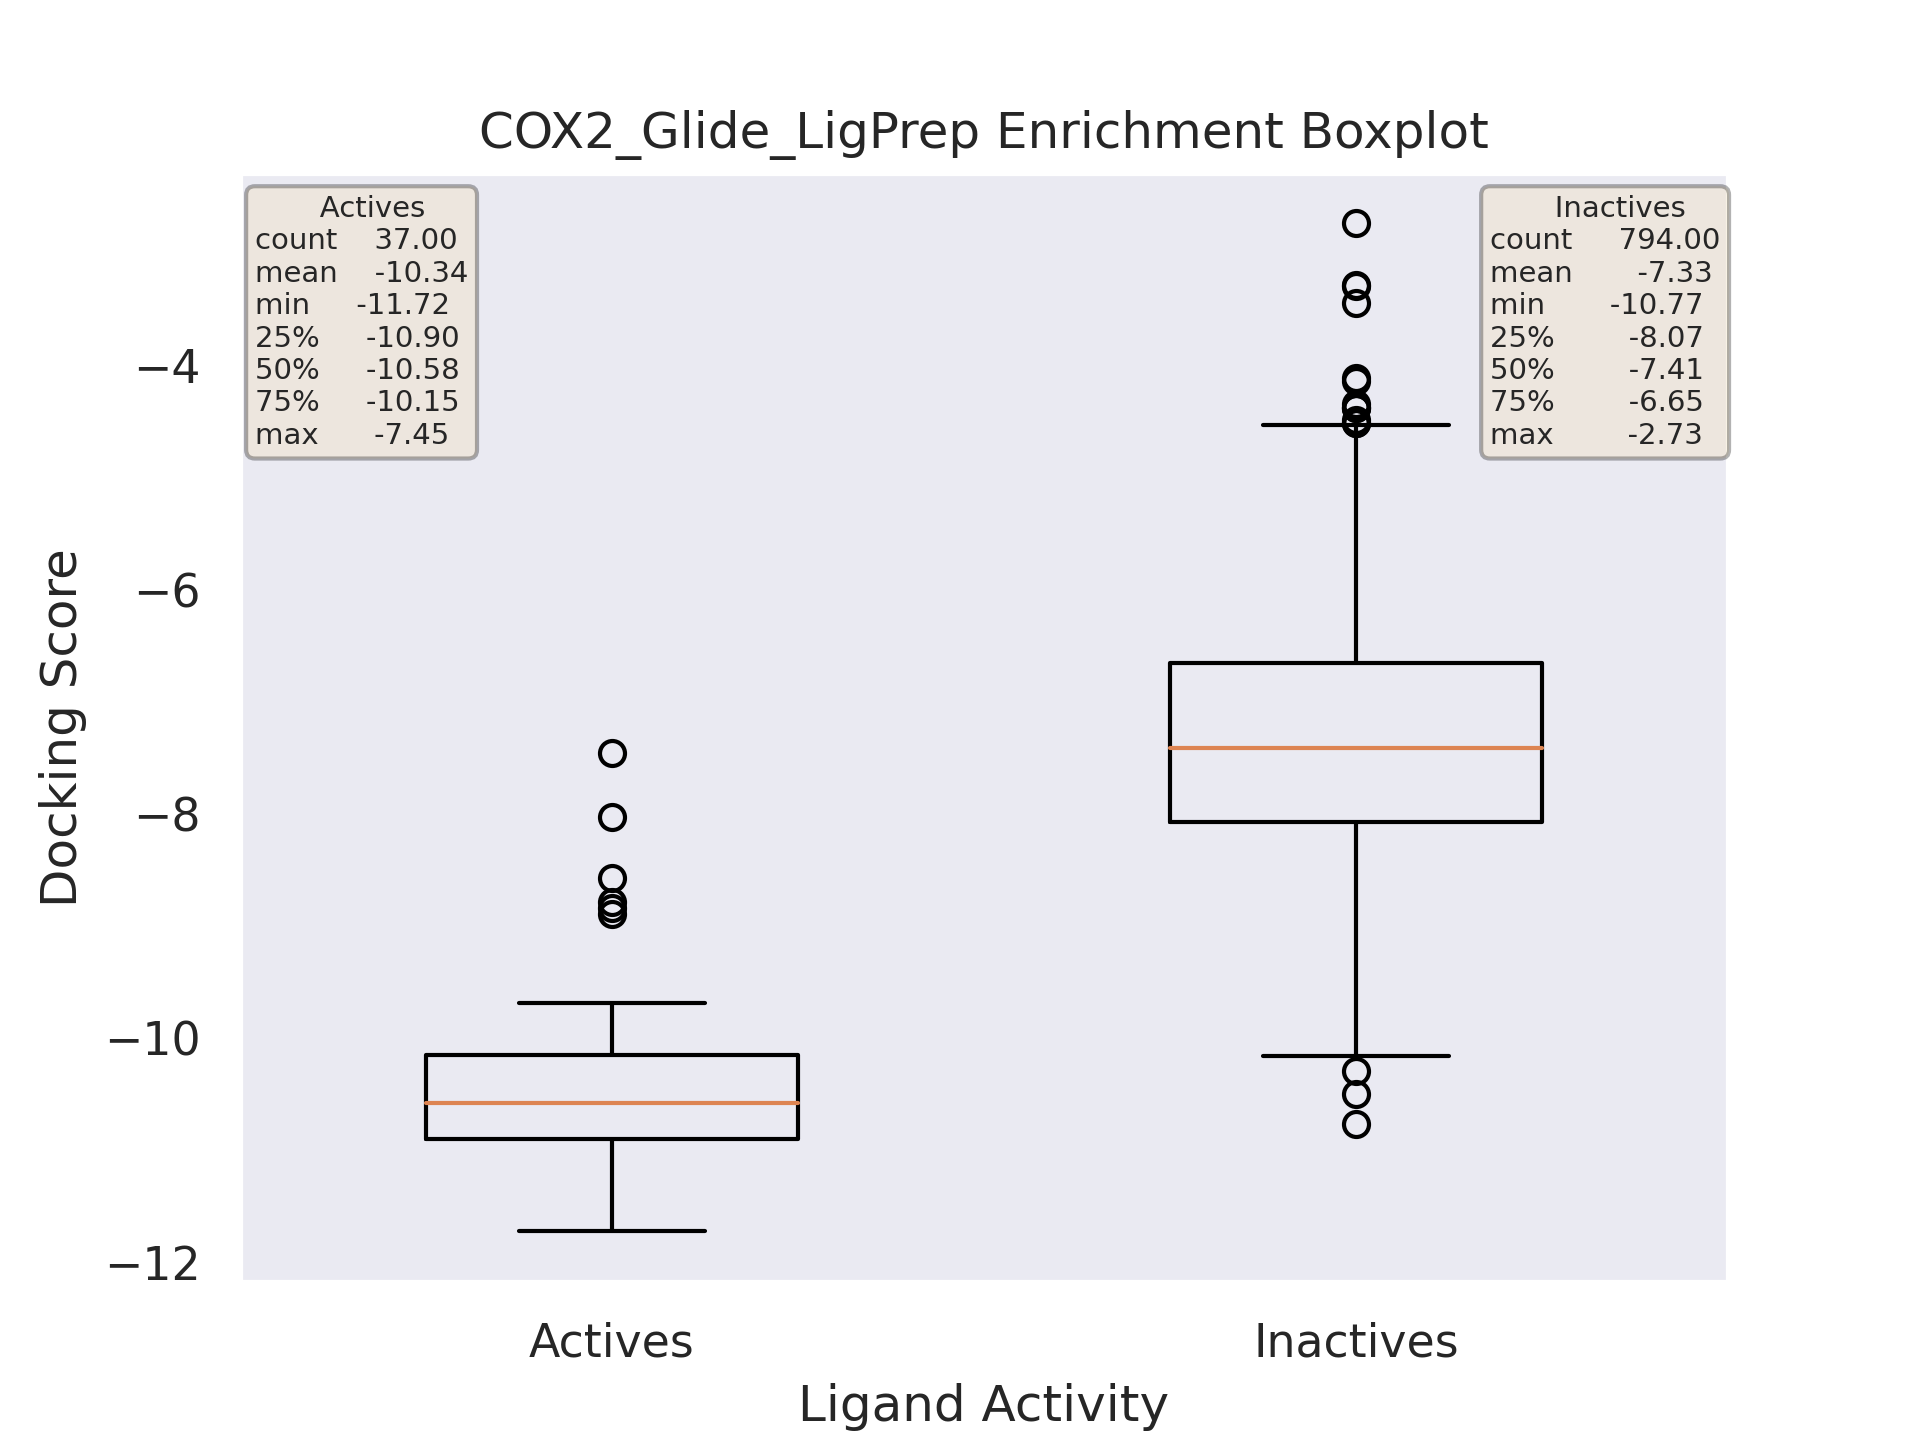
</div>

The enrichment boxplot can better illustrate enrichment in imbalanced datasets. In contrast to the enrichment histogram above, the relatively small sample size of actives does not obscure visibility of its data spread. It is again evident that there is enrichment given the docking scores for the active ligands is generally better than the inactive ligands. Important features of a boxplot are listed below:

* The orange line in the middle of each box is the median
* The 2 sides of the box on either side of the orange line represent Q1 (25th percentile) and Q3 (75th percentile)
* The interquartile range is defined as the difference between Q3 and Q1 --> IQR = Q3 - Q1
* The 2 endpoints of the boxplot are the points Q1 - 1.5 * IQR and Q3 + 1.5 * IQR --> most points are within these   "extremes"
* Outliers are points outside the "extremes" (defined above) and are represented by circles

The above listed metrics are all visible in text boxes pasted directly on the boxplot. `"Count"` is the number of data points in each ligand type (e.g. there are 37 active ligands).

Next, a pROC curve and an accompanying `JSON` containing the area under the curve (AUC) is saved to the output folder. The pROC curve provides an additional qualitative evaluation of enrichment while the AUC facilitates quantitative comparison. Please see `Appendix: Analysis Metrics` at the end of the notebook for more details regarding the pROC curve and AUC. Let's take a look at the pROC curve.

<div>
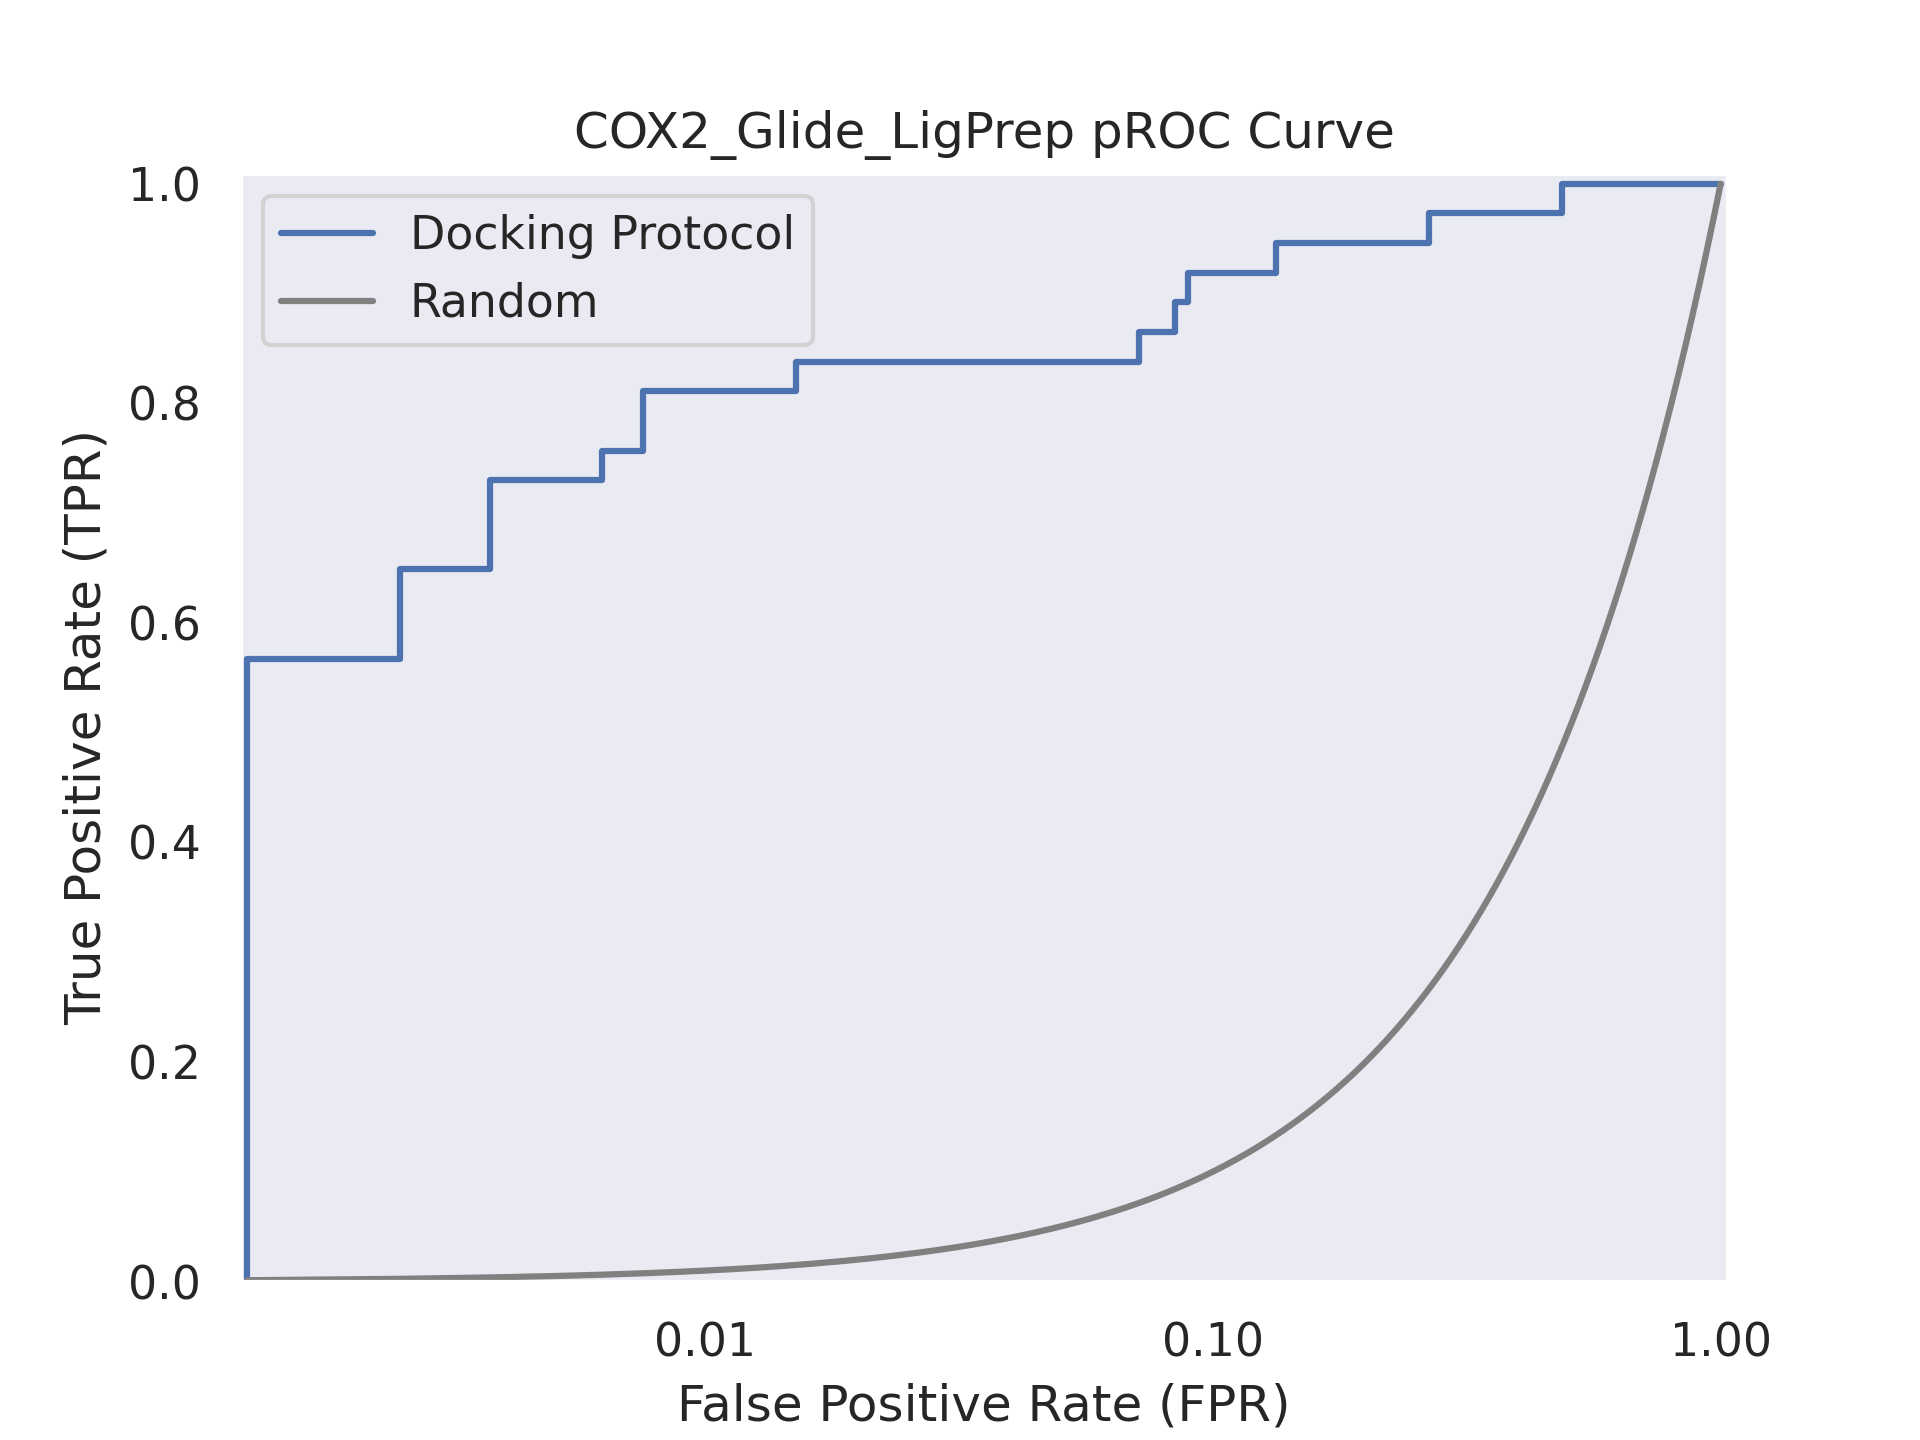
</div>

`"Random"` corresponds to a docking protocol randomly classifies active and inactive ligands. It is necessarily the case that the docking protocol must be better than this `"Random"` classifier. Any curve that is to the left of the random curve displays enrichment. The AUC can be used to quantitatively compare docking protocols. Let's take a look at the output `JSON` that reports this metric.

`
{
  "Random": 0.434,
  "COX2_Glide_LigPrep": 2.412
}
`

A random classifier always has a AUC of 0.434. Any value greater than 0.434 is considered enrichment.

Finally, the Enrichment Factor for the top 5% ligands (EF 5%) is calculated. Please see `Appendix: Analysis Metrics` at the end of the notebook for more details. Any value greater than 0 means there are active ligands that do indeed score within the top 5% ligands (including decoys). Similar to the pROC AUC, the EF 5% is provided in the corresponding output `JSON`.

`
{
  "Docking Experiment EF 5%": 16.22
}
`

**Note:** In the explanations above, active ligands were described as having a "better" docking score than inactive ligands. This is because depending on the backend + scoring function chosen, "better" can mean lower or higher. For example, the plots above are the result of `Glide` docking which follows the rule, "lower scores are better". In contrast, `GOLD` using its `GoldScore` scoring function follows the rule, "higher scores are better". In this case, nothing needs to be changed when running `Enrichment Analysis` but do take note of the "scoring function rule" when analyzing the enrichment histogram and boxplot

`Enrichment Analysis` supports batch execution - if you want to generate enrichment histograms, boxplots, pROC curves, and calculated pROC AUC for a batch of `DockStream` runs, simply provide the paths to the folders containing the `DockStream` output for the active and inactive ligands.

**Important:** The active and inactive data are matched based on the file names (Ex. COX2_Glide_LigPrep.csv in the actives folder is matched to COX2_Glide_LigPrep.csv in the inactives folder). Therefore, it is recommended when executing `DockStream` for the purpose of batch `Enrichment Analysis` that the actives and inactives are run separately and the output saved to separate folders. Ensure the output `CSV` names are identical.

COX2 and QPCT `Glide` docking data is provided. Previously, the configuration `JSON` was constructed by providing the absolute path to the COX2 active and inactive ligands data. This time, let's generate a configuration `JSON` by providing the absolute path to the folder which contains both the COX2 and QPCT active and inactive ligands data. 

In [7]:
# generate the paths to the actives and inactives data folder shipped with this implementation
ACTIVES_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/Active")
INACTIVES_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Enrichment/Inactive")

In [8]:
batch_enrichment_json = {
  "input_docking_data": {
    "data_path": "---",
    "data_metric": "---",
    "max_data_metric_best": "---",
    "data_thresholds": "---"
  },
  "input_exp_data": {
    "exp_data_path": "---",
    "exp_metric": "---",
    "max_exp_metric_best": "---",
    "exp_thresholds": "---"
  },
  "input_enrichment_data": { 
    "data_path_actives": ACTIVES_PATH,          # path to the DockStream output folder for the active ligands
    "data_path_inactives": INACTIVES_PATH,      # path to the DockStream output folder for the inactive ligands
    "actives_data_metric": "score",             # active ligands activity metric
    "inactives_data_metric": "score",           # inactive ligands activity metric
    "max_metric_best": "False"                  # denotes whether a greater value is better (ex. GOLD GoldScore)
  },
  "plot_settings": {
    "enrichment_analysis": "True",              # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                     # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": enrichment_results_dir       # desired output directory
  }
}

with open(os.path.join(output_dir, "batch_enrichment.json"), "w+") as f:
    json.dump(batch_enrichment_json, f, indent=2)

Let's now execute the `Analysis Script` with the new configuration `JSON` above.

In [9]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "batch_enrichment.json")}

Batch enrichment histograms, boxplots, and pROC curves constructed. Exiting script now.


Notice in the output folder, there is now a histogram, boxplot, and pROC curve for both the COX2 and QPCT `Glide` data. For brevity, the new plots are not shown. Only the pROC AUC and EF 5% `JSONs` are shown.

**pROC AUC Values**

`{
  "Random": 0.434,
  "COX2_Glide_LigPrep": 2.412,
  "QPCT_Glide_CTE": 0.343
}`

**EF 5%**

`
{
  "COX2_Glide_LigPrep": 16.22,
  "QPCT_Glide_CTE": 0.0
}
`

All pROC AUC and EF 5% values are stored in the output `JSONs` (there are now pROC values for COX2 **and** QPCT) and allows one to easily screen through many `Enrichment Analysis` runs.


Finally, the last functionality available via `Enrichment Analysis` is the generation of overlay pROC curves. These plots can be especially useful to qualitatively assess a batch of `DockStream` results. The configuration `JSON` required is identical to the batch `Enrichment Analysis` `JSON` above except **`"pROC_overlay" = "True"`**. Let's generate the configuration `JSON`.

In [10]:
pROC_overlay_enrichment_json = {
  "input_docking_data": {
    "data_path": "---",
    "data_metric": "---",
    "max_data_metric_best": "---",
    "data_thresholds": "---"
  },
  "input_exp_data": {
    "exp_data_path": "---",
    "exp_metric": "---",
    "max_exp_metric_best": "---",
    "exp_thresholds": "---"
  },
  "input_enrichment_data": { 
    "data_path_actives": ACTIVES_PATH,          # path to the DockStream output folder for the active ligands
    "data_path_inactives": INACTIVES_PATH,      # path to the DockStream output folder for the inactive ligands
    "actives_data_metric": "score",             # active ligands activity metric
    "inactives_data_metric": "score",           # inactive ligands activity metric
    "max_metric_best": "False"                  # denotes whether a greater value is better (ex. GOLD GoldScore)
  },
  "plot_settings": {
    "enrichment_analysis": "True",              # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "True"                      # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": enrichment_results_dir       # desired output directory
  }
}

with open(os.path.join(output_dir, "pROC_overlay_enrichment.json"), "w+") as f:
    json.dump(pROC_overlay_enrichment_json, f, indent=2)

Notice `"data_path_actives"` and `"data_path_inactives"` are paths to the folders containing *all* the active and inactive ligands data. The same guidelines for file names are relevant here and stated again below:

**Important:** The active and inactive data are matched based on the file names (Ex. COX2_Glide_LigPrep.csv in the actives folder is matched to COX2_Glide_LigPrep.csv in the inactives folder). Therefore, it is recommended when executing `DockStream` for the purpose of generating overlay pROC curves that the actives and inactives are run separately and the output saved to separate folders. Ensure the output `CSV` names are identical.

Let's now execute the `Analysis Script` to generate an overlay pROC curve.

In [11]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "pROC_overlay_enrichment.json")}

Overlay pROC curves plot generated. All pROC AUC calculated. Exiting script now.


Let's take a look at the overlay pROC curve and the output pROC AUC `JSON`.

<div>
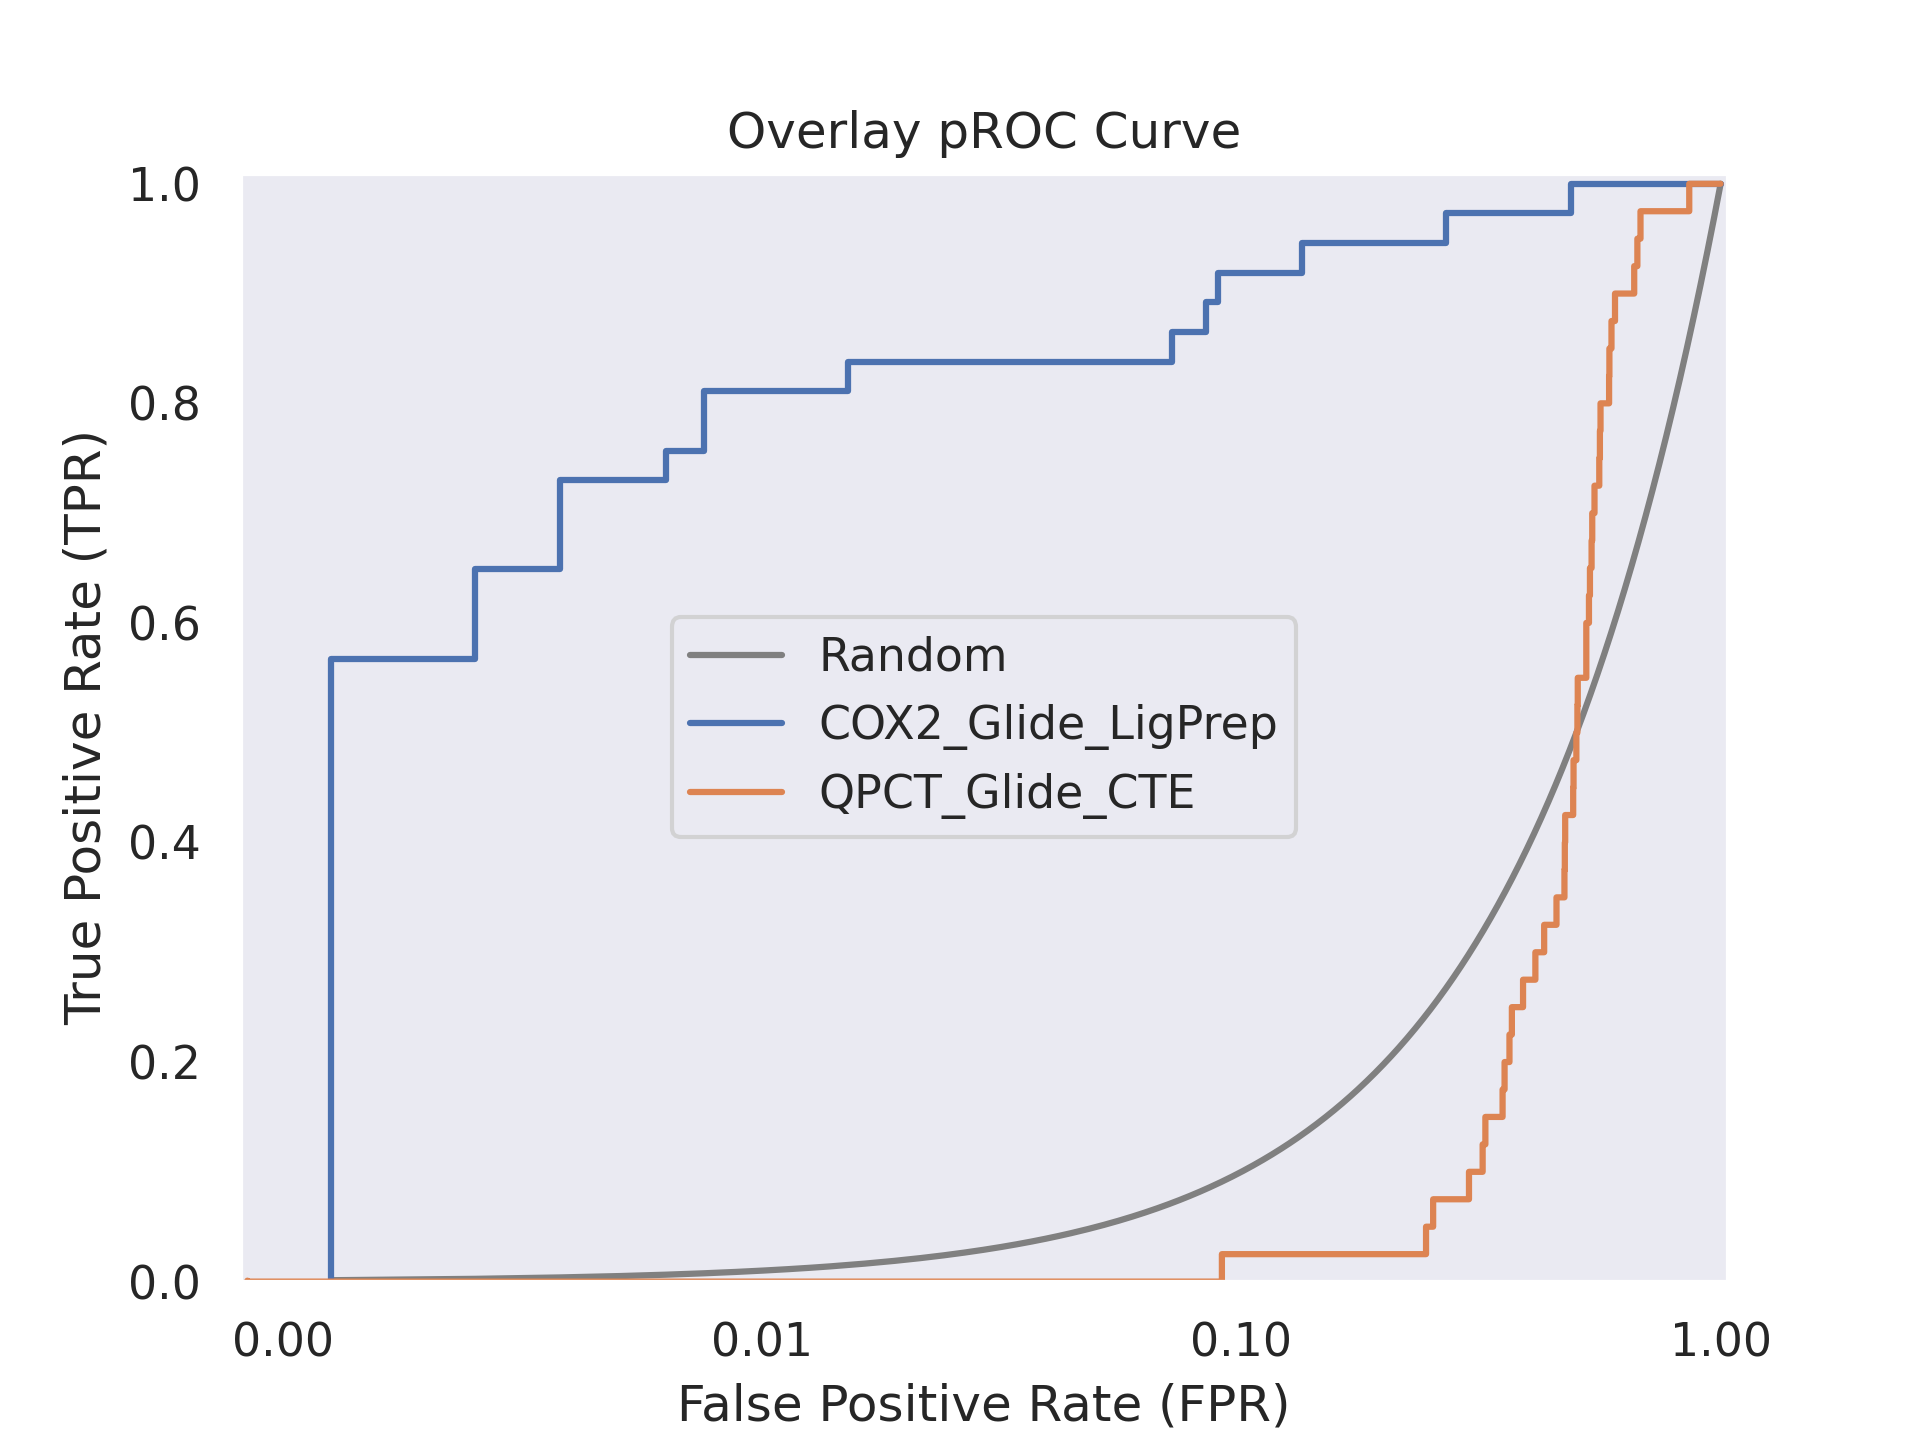
</div>

The overlay pROC curve allows one to easily observe that COX2 displays significantly more enrichment than QPCT. This is reaffirmed quantitatively in the pROC AUC `JSON`:

`{
  "Random": 0.434,
  "COX2_Glide_LigPrep": 2.412,
  "QPCT_Glide_CTE": 0.343
}`

Finally, the EF 5% values are also outputted as in the case of batch `Enrichment Analysis`.

`
{
  "COX2_Glide_LigPrep": 16.22,
  "QPCT_Glide_CTE": 0.0
}
`

# 2. Correlation Analysis

Suppose you are involved in a hit discovery and/or lead optimization project. You are interested in applying `DockStream` to help guide experimental efforts. Specifically, you want to determine the backend + ligand embedder + settings combination (e.g. `Glide with LigPrep` and `"SP"` precision) that performs "best" for your ligand-receptor system. "Best" here is defined as the configuration that yields the best correlation between docking scores and experimental data (ex. in the perfect scenario, a better docking score always equates to a more potent compound). One can imagine that the choice of backend + ligand embedder + settings (some sort of "hyper-parameters") leads to a combinatorial explosion of possibilities. The `Benchmarking script` was introduced to automate and streamline batch execution of `DockStream`. The `Analysis Script` and specfically its `Correlation Analysis` functionality was introduced to automate and streamline the quantitative correlation comparison between batch `DockStream` runs. The purpose is to allow the user to relatively easily compare and identify the best docking configuration for their project. This process is useful as a standalone *in silico* design component but also provides a good integration point for `REINVENT` where identifying the "best" docking configuration will structurally inform `REINVENT` runs. The dataset used in this section is from the D3R Grand Challenge which provides open access to experimental assay data. For more information see:

https://drugdesigndata.org/

The Urokinase dataset released by Abbott was chosen for `Correlation Analysis` demonstration. The dataset was sampled to take only the active ligands which were then docked using `GOLD` and `Hybrid` and the `DockStream` output is shipped with the `DockStream` codebase. Note that `GOLD` and `Hybrid` were chosen as backends arbitrarily - `Correlation Analysis` is compatible with any backend. Let's take a look at the `GOLD` and `Hybrid` docking data and the Urokinase experimental data.

In [12]:
# generate the paths to the Hybrid docking data, the folder containg both Hybrid and GOLD docking data, 
# and the experimental data shipped with this implementation
HYBRID_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/DockStream_Output/Urokinase_Hybrid_Docking_Data.csv")
DOCKING_DATA_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/DockStream_Output")
EXP_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/Urokinase_Exp_Data.csv")

# read the GOLD and Hybrid docking data and experimental data to show its contents
GOLD_DATA = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/DockStream_Output/Urokinase_GOLD_Docking_Data.csv"))
HYBRID_DATA = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/DockStream_Output/Urokinase_Hybrid_Docking_Data.csv"))
EXP_DATA = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Correlation/Urokinase_Exp_Data.csv"))

In [13]:
GOLD_DATA.head(3)

,ligand_number,enumeration,conformer_number,name,score,smiles,lowest_conformer
0,0,0,0,0:0:0,58.0203,COC(=O)Nc1cccc2c1cc(cc2)C(=[NH2+])N,True
1,1,0,0,1:0:0,66.1756,CC(C)n1cc(cn1)c2c(ccc3c2cc(cc3)C(=[NH2+])N)OC,True
2,2,0,0,2:0:0,65.7353,c1ccc(cc1)NC(=O)Nc2ccc3cc(ccc3c2)C(=[NH2+])N,True


In [14]:
HYBRID_DATA.head(3)

,ligand_number,enumeration,conformer_number,name,score,smiles,lowest_conformer
0,0,0,0,0:0:0,-9.497414,COC(=O)Nc1cccc2c1cc(cc2)C(=[NH2+])N,True
1,1,0,0,1:0:0,-10.227792,CC(C)n1cc(cn1)c2c(ccc3c2cc(cc3)C(=[NH2+])N)OC,True
2,2,0,0,2:0:0,-9.293001,c1ccc(cc1)NC(=O)Nc2ccc3cc(ccc3c2)C(=[NH2+])N,True


In [15]:
EXP_DATA.head(3)

,ligand_number,Ki (nM),Log Ki (nM)
0,0,40.0,1.602060
1,1,4500.0,3.653213
2,2,610.0,2.785330


The above cells display the first 3 entries in the Urokinase `GOLD` and `Hybrid` `DockStream` output. The important observation is that the `CSV` files provided are simply the raw and unmodified `DockStream` output `CSVs`.

The first 3 entries in the Urokinase assay activity is also displayed. There have been some slight processing of the raw data. Notably, the `Ki (nM)` has been log transformed simply to create a better suited y-scale for plotting. In addition, the `Log Ki (nM)` is mapped to the ligand via `"ligand_number"` which is internally generated following `DockStream` execution (i.e. each ligand is given a `"ligand_number"` in the raw and unmodified `DockStream` output `CSVs`). Manually creating this experimental data file is unfortunately required but only needs to be done once. We will now demonstrate the generation of a scatter plot and an output `JSON` which contains relevant statistics metrics. Similar to the `Benchmarking Script`, a configuration `JSON` is required as an input argument. Let's take a look at the `Analysis Script` configuration `JSON` as applied to `Correlation Analysis`. 

In [16]:
correlation_json = {
  "input_docking_data": {
    "data_path": HYBRID_PATH,               # path to the docking data
    "data_metric": "score",                 # docked ligands activity metric
    "max_data_metric_best": "False",        # denotes whether a greater docking score = greater predicted affinity
    "data_thresholds": "N/A"                # must be "N/A" for correlation analysis
  },
  "input_exp_data": {
    "exp_data_path": EXP_PATH,              # path to the experimental data
    "exp_metric": "Log Ki (nM)",            # experimental data activity metric
    "max_exp_metric_best": "False",         # denotes whether a greater value = greater affinity/potency
    "exp_thresholds": "N/A"                 # must be "N/A" for correlation analysis
  },
  "input_enrichment_data": { 
    "data_path_actives": "---",       
    "data_path_inactives": "---",   
    "actives_data_metric": "---",          
    "inactives_data_metric": "---",      
    "max_metric_best": "---"                
  },
  "plot_settings": {
    "enrichment_analysis": "False",         # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                 # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": correlation_results_dir  # desired output directory
  }
}

with open(os.path.join(output_dir, "correlation.json"), "w+") as f:
    json.dump(correlation_json, f, indent=2)

The relevant parameters for a `Correlation Analysis` configuration JSON are elaborated below:

* `"data_path" / "exp_data_path"`

Path to a `CSV` file or a folder containing `CSV` files (as we will see later) containing the docking/experimental data. The `CSV` files are typically the raw and unmodified `DockStream` output. It is perfectly fine for this `CSV` to be any `CSV` file as long as it contains a column that contains the activity data (e.g. for `DockStream` output, the activity data will be `"score"` which represents the docking score).

* `"data_metric" / "exp_metric"`

String that denotes the name of the activity metric for the docking/experimental data in their corresponding `CSV` files. Typically, `"data_metric"` will be `"score"` as the most common use case will be inputting the raw and unmodified `DockStream` output. The `"exp_metric"` will be project specific - the example in this section is `"Log Ki (nM)"`.

* `"max_data_metric_best" / "max_exp_metric_best"`

Boolean which denotes whether a greater value = greater affinity/potency (e.g. for `Glide` docking scores, the lower the score, the greater the predicted binding affinity - `"max_data_metric_best"` = "False"). Suppose you have `"pIC50"` values - this would require `"max_exp_metric_best"` = "True".

* `"data_thresholds" / "exp_thresholds"`

These parameters are relevant for `Threshold Analysis` which is introduced in the next section. For `Correlation Analysis`, these parameters must be set to `"N/A"`.

* `"enrichment_analysis"`

Boolean which denotes whether the user wants to perform `Enrichment Analysis`. This parameter takes only 2 possible values: `"True"` or `"False"`. For `Correlation Analysis`, it must be set to `"False"`.

* `"pROC_overlay"`

Boolean which denotes whether the user wants to generate *only* an overlay pROC curve. This parameter is only parsed if `"enrichment_analysis"` = `"True"`. Set to `"False"` for `Correlation Analysis`


* "output_path"

Path to the desired output directory. This is where all the output of the `Analysis Script` execution will be saved.

Let's now execute the `Analysis Script` with the configuration `JSON` above.

In [ ]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "correlation.json")}

After executing the above cell block, a scatter plot and a `JSON` containing calculated metrics are saved into the specified output directory. Let's take a look at the scatter plot.

<div>
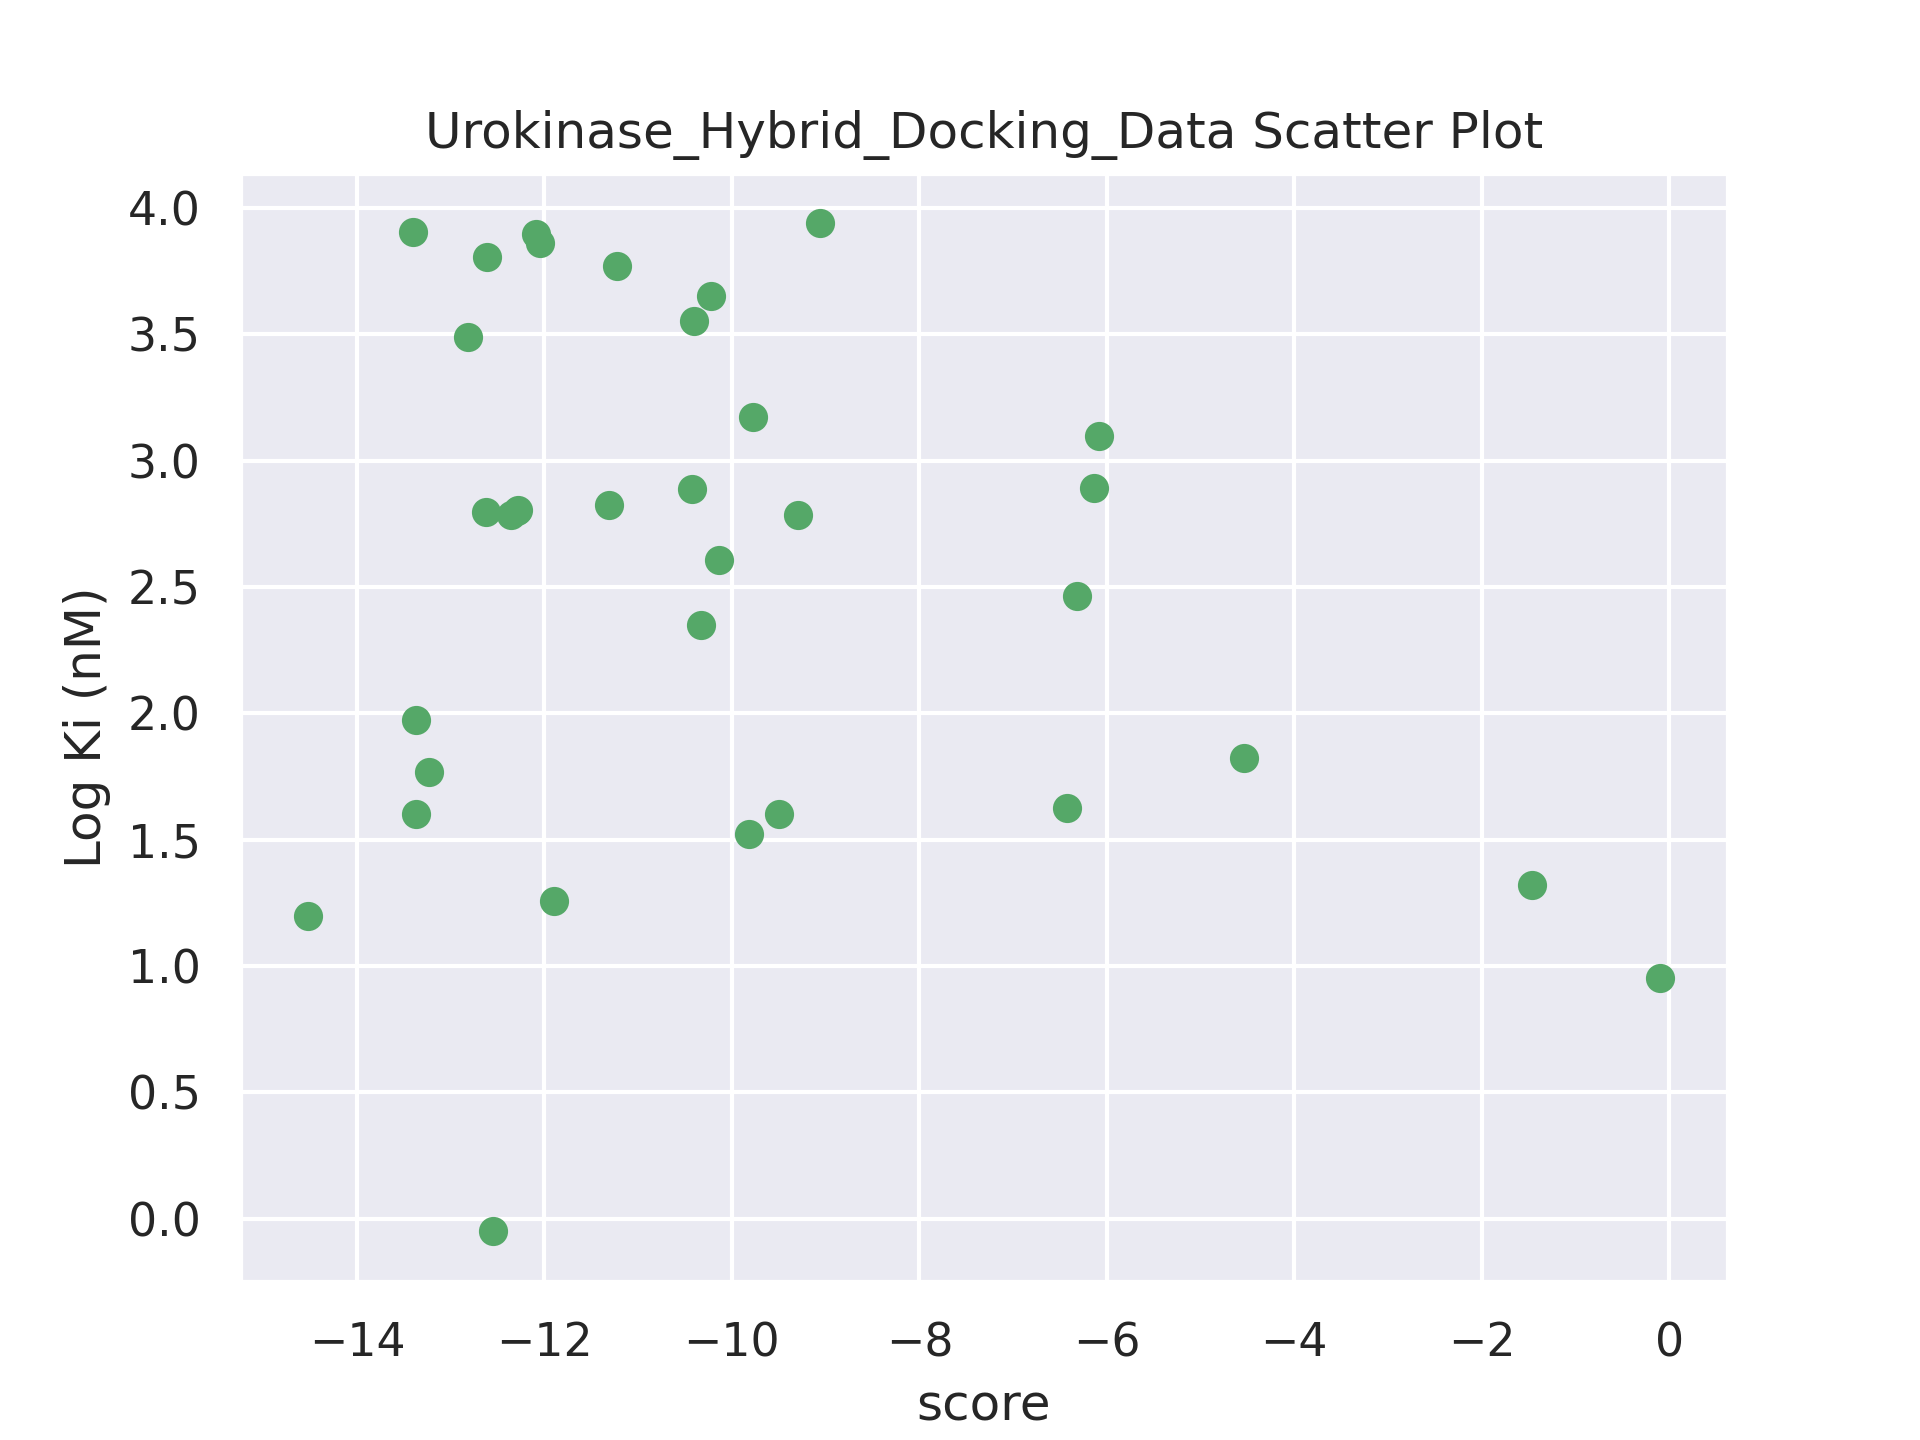
</div>

The title of the scatter plot is extracted from the `CSV` file name. The x and y axes labels are extracted from the "data_metric" and `"exp_metric"` parameters in the configuration `JSON` described previously. The scatter plot shows the distribution of (docking score, experimental activity) pairs. Correlation metrics are also computed and are saved in a `JSON` file for readibility. Let's take a look at the `JSON`.

`{
  "Urokinase_Hybrid_Docking_Data.csv": {
    "coeff_determination": 0.057778420203442704,
    "Spearman_coeff": -0.09245110132393133,
    "Kendall_coeff": -0.058928665383788846
  }
}`

The `JSON` displays the origin of the data in the header (e.g. "Urokinase_Hybrid_Docking.csv"). The 3 correlation metrics computed are The Coefficient of Determination ($R^{2}$) and Spearman ($\rho$) and Kendall ($\tau$) Correlation. Please see `Appendix: Analysis Metrics` at the end of this notebook for details regarding each metric. 

**Practical Note:**  Do take note of repeated values in your dataset. A common occurrence of this is when the experimental assay caps output values at the limit of quantification, LOQ (e.g. pIC50 capping at 4 M). These "inactive ligands" will skew the correlation metrics and one may consider removing these data points. Doing so will generally improve the correlation metrics and may yield a more meaningful interpretation. However, the same can be said for retaining these data points; removing repeated metrics inherently causes loss of information which could be detrimental

**Important Note:** "Conventionally", correlation scores are positive when an increase in the `x variable` is matched by an increase in the `y variable` and vice versa.  Unfortunately, depending on the docking backend and the experimental assay, docking scores and experimental activity metrics may follow either the rule "lower scores are better" or "higher scores are better". Consider the case with `Glide` docking scores and accompanying `"pIC50"` values. Lower `Glide` scores are better and greater `"pIC50"` scores are better. Therefore, a negative correlation value is actually good! To avoid any ambiguities, these discrepancies are handled internally to follow the "conventional" interpretation: A positive correlation value **always** means a "better" docking score yields a "better" experimental activity value regardless of the metrics used as long as the `"max_data_metric_best"` and `"max_exp_metric_best"` are properly assigned in the configuration `JSON`. Therefore, if you observe that the correlation metric is negative, it does indeed mean that the docking scores do not exhibit positive correlation with the experimental activity values (i.e. the docking configuration is not well suited for the project).

Now suppose you want to perform `Correlation Analysis` on many `DockStream` runs. In this section, we provided `GOLD` and `Hybrid` docking data. Previously, only `Hybrid` was analyzed. `Correlation Analysis` supports batch execution. Simply create a folder to hold all the `DockStream` output `CSV` files and pass this path as the `"data_path"` argument in the analysis configuration `JSON` - let's take a look. 

In [18]:
# note everything is the same as the JSON above except the "data_path" parameter whose value is now a folder
batch_correlation_json = {
  "input_docking_data": {
    "data_path": DOCKING_DATA_PATH,         # path to the docking data folder
    "data_metric": "score",                 # docked ligands activity metric
    "max_data_metric_best": "False",        # denotes whether a greater docking score = greater predicted affinity
    "data_thresholds": "N/A"                # must be "N/A" for correlation analysis
  },
  "input_exp_data": {
    "exp_data_path": EXP_PATH,              # path to the experimental data
    "exp_metric": "Log Ki (nM)",            # experimental data activity metric
    "max_exp_metric_best": "False",         # denotes whether a greater value = greater affinity/potency
    "exp_thresholds": "N/A"                 # must be "N/A" for correlation analysis
  },
  "input_enrichment_data": { 
    "data_path_actives": "---",       
    "data_path_inactives": "---",   
    "actives_data_metric": "---",          
    "inactives_data_metric": "---",      
    "max_metric_best": "---"                
  },
  "plot_settings": {
    "enrichment_analysis": "False",         # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                 # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": correlation_results_dir  # desired output directory
  }
}

with open(os.path.join(output_dir, "batch_correlation.json"), "w+") as f:
    json.dump(batch_correlation_json, f, indent=2)

Let's execute batch `correlation analysis`.

In [ ]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "batch_correlation.json")}

After executing the above cell block, scatter plots for both the `Hybrid` and `GOLD` run and a `JSON` containing calculated metrics are saved into the specified output directory. There are now 2 scatter plots:

<div>
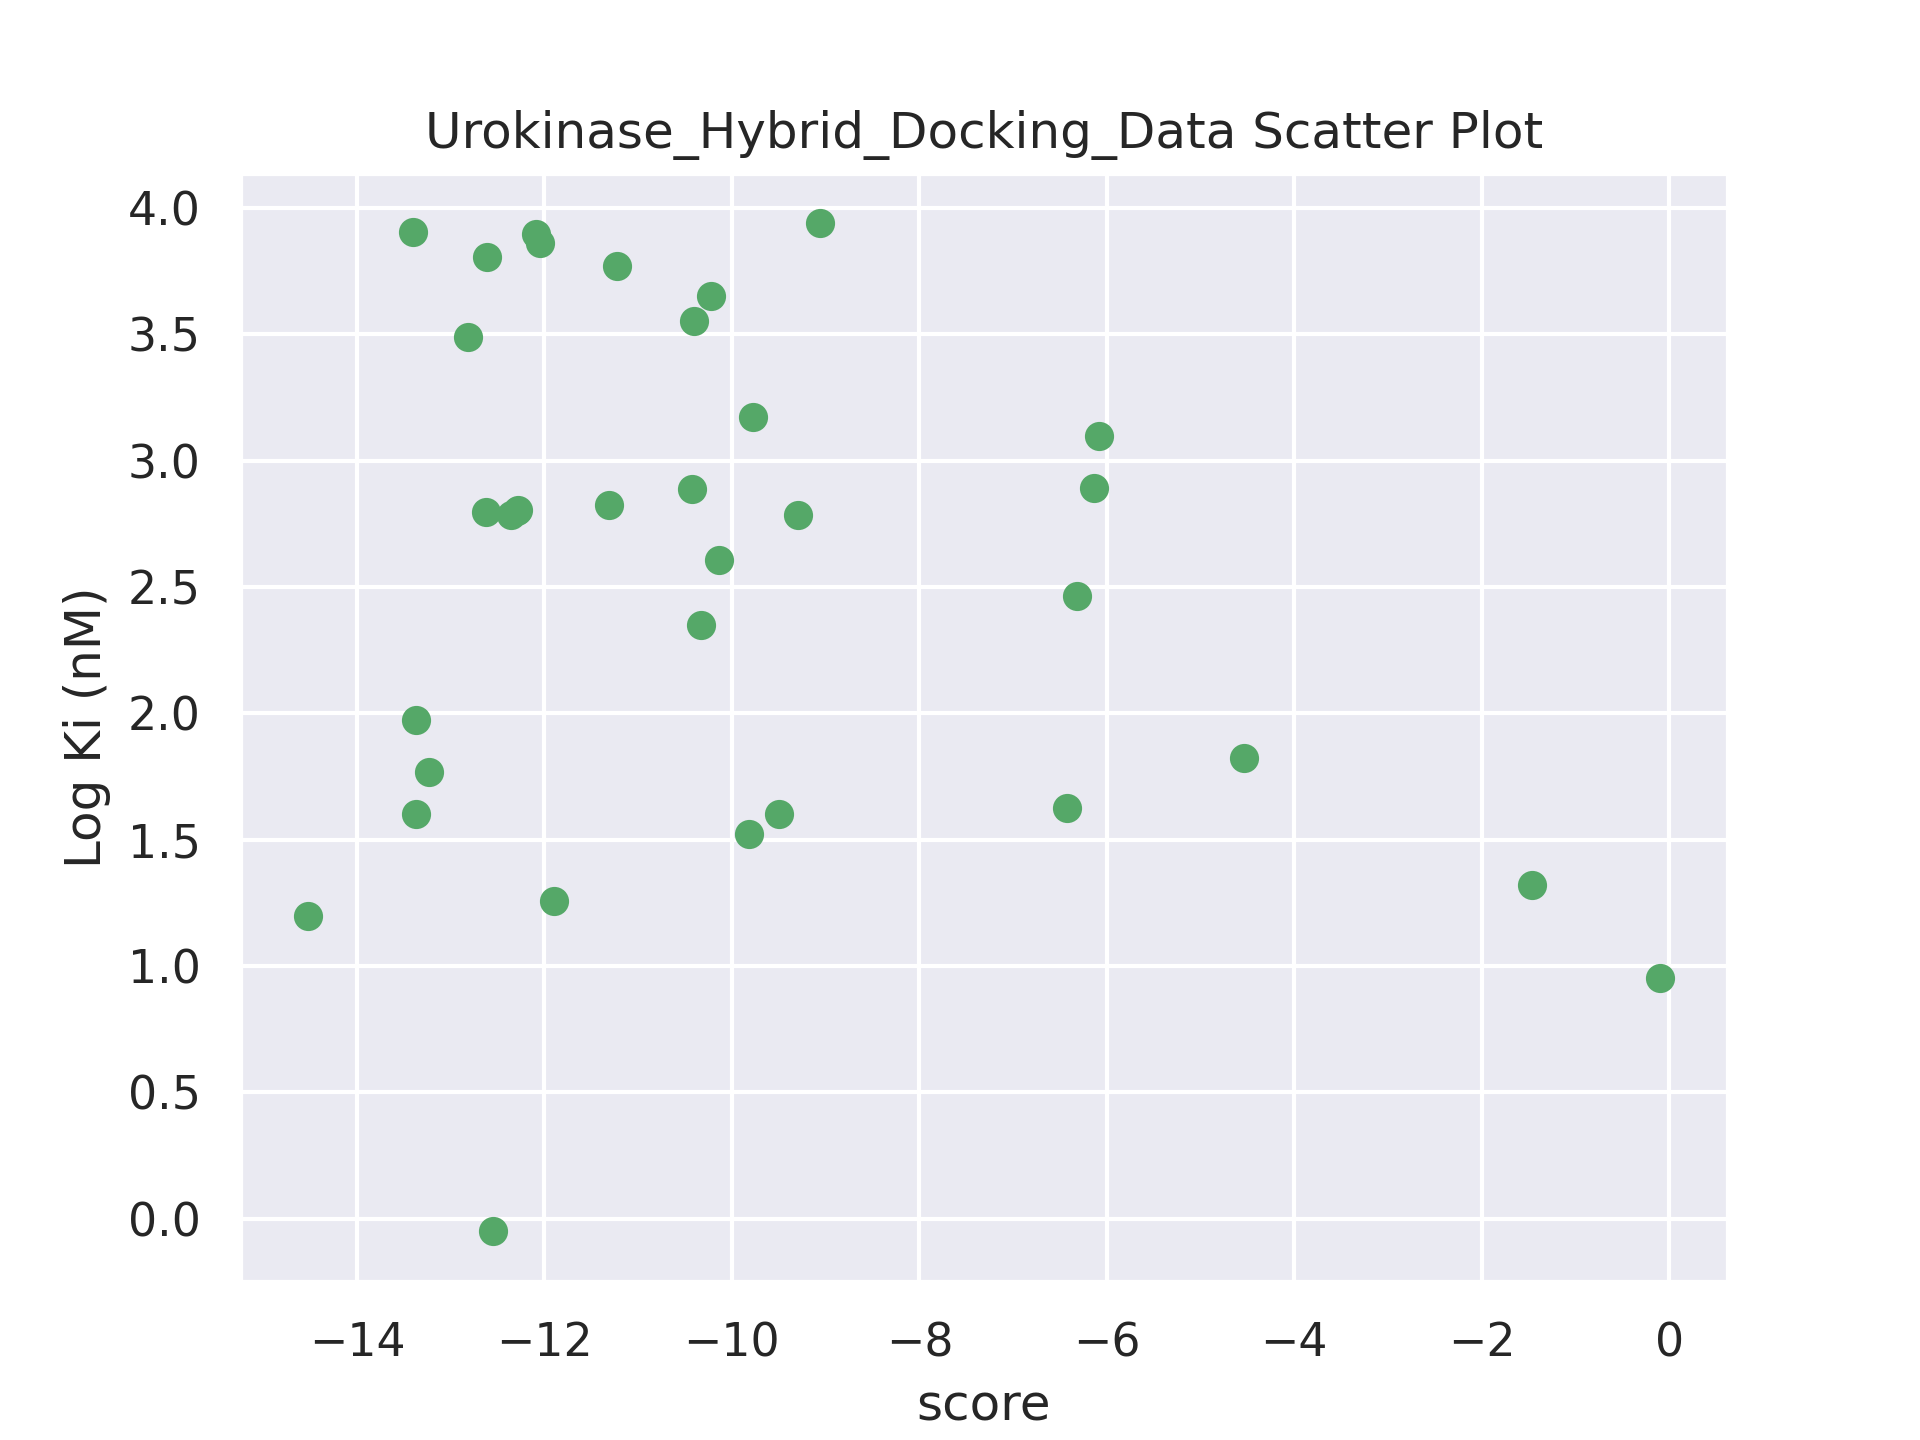
</div>

The above scatter plot is the exact same plot as previously generated.

<div>
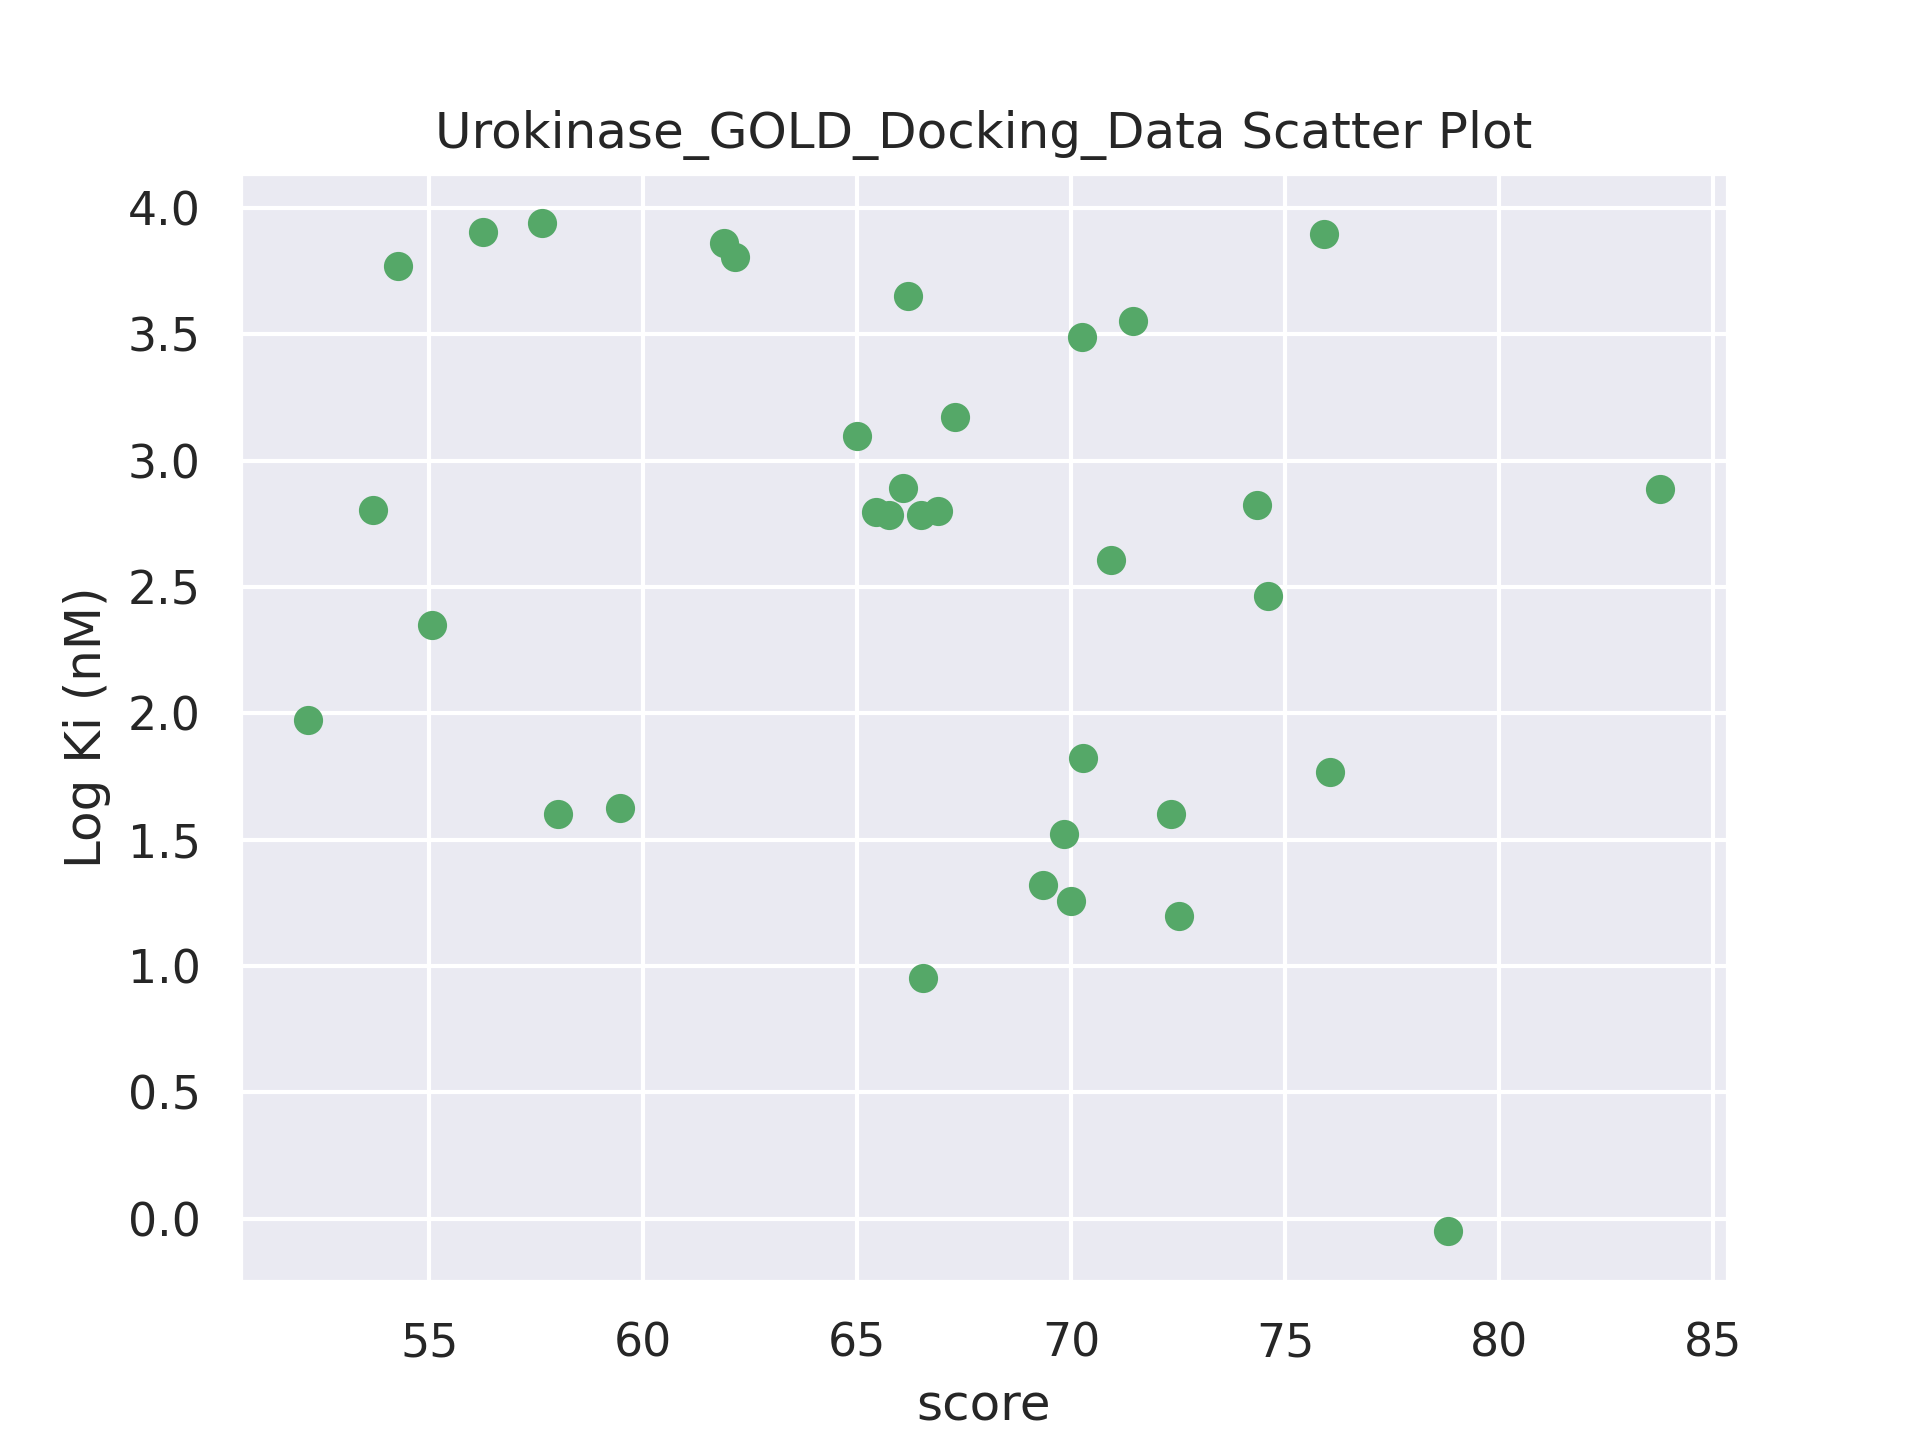
</div>

The above scatter plot is now generated as well when `Analysis Script` is called. In practise, there is no limit to the number of scatter plots that can be generated. This is simply controlled by how many `DockStream` output `CSV` files are provided in the input folder. The correlation metrics are also computed for all runs and instead of 1 `JSON` per run, all the metrics are compiled into a single `JSON`. Let's take a look.

`{
  "Urokinase_GOLD_Docking_Data.csv": {
    "coeff_determination": 0.07536299287923043,
    "Spearman_coeff": -0.28606357302214785,
    "Kendall_coeff": -0.20178603601115574
  },
  "Urokinase_Hybrid_Docking_Data.csv": {
    "coeff_determination": 0.057778420203442704,
    "Spearman_coeff": -0.09245110132393133,
    "Kendall_coeff": -0.058928665383788846
  }
}`

The header once again displays the origins of the data with the corresponding correlation metrics. The `JSON` would simply be longer if there were more `DockStream` output `CSV` files analyzed.


**Warning:** Notice the ranked correlation metrics for `GOLD` and `Hybrid` are negative. This is indeed the case for `Hybrid`, but they should actually be positive for `GOLD` because the `GoldScore` scoring function was used (higher scores = better scores). The reason for this is because in the configuration JSON, `"max_data_metric_best"` was set to `False`. Therefore, when running batch `Correlation Analysis`, keep in the mind the nature of the scoring functions. In this case, please multiply the `GOLD` correlation metrics by -1.  Conversely, if `"max_data_metric_best"` were set to `True`, the `GOLD` `GoldScore` correlation metrics would be correct but the `Hybrid` correlation metrics would need to be multiplied by -1. This discrepancy is most prevalent when running large batch `Correlation Analysis` with many "higher scores = better scores" and "lower scores = better scores" scoring functions

# 3. Thresholds Analysis

Suppose you are now later in a project such as at the lead optimization phase. You have previously applied `DockStream` to guide synthetic efforts and have now obtained some experimental activity data. You may now want to set-up another iteration of `DockStream` experiments but before doing so, you are interested in observing the distribution of "active" and "inactive" ligands. "Active" and "inactive" are in quotations here because you may want to consider a ligand "active" / "inactive" given a concrete threshold value (e.g. `Glide` docking scores <= -10 are considered docking active and `"pIC50"` values > 5.5 are considered experimentally active). Given these thresholds, what is the distribution of your ligand set? Thresholds that yield a favorable distribution may help guide further computational experiments (e.g. only consider docking scores better than a certain threshold).

Alternatively, it may be the case that docking protocols fail to yield any observed correlation with experimental data. For instance, you may have applied `Correlation Analysis` to evaluate many `DockStream` runs but they all show extremely poor correlation. In this situation, it can be valuable to investigate whether setting thresholds can facilitate a general separation of your data.

`Thresholds Analysis` addresses these questions and contains all the capabilities of `Correlation Analysis` (scatter plot generation and calculation of statistics metrics) but with added features. Notably, confusion matrices and stacked histograms are generated to facilitate qualitative and quantitative comparison of the distribution of `true positives` (docking active and experimentally active), `true negatives` (docking inactive and experimentally inactive), `false positives` (docking active and experimentally inactive), and `false negatives` (docking inactive and experimentally active). The ligands are classified into these labels given user specified thresholds. 

**Classification Example**: Consider the user provided thresholds pair of (`-7 Glide` docking score, `3 Log Kd`):
* `Glide` docking score <= -7 = docking active and `Glide` docking score > -7 = docking inactive
* `Log Kd` value <= 3 = experimentally active and `Log Kd` value > 3 = experimentally inactive
* `true positive` = docking active and experimentally active (ex. -8 `Glide` docking score and 2 `Log Kd`

The dataset used in this section is from the D3R Grand Challenge which provides open access to experimental assay data. For more information:

https://drugdesigndata.org/

The CHK1 Kinase dataset released by Abbott was chosen for `Thresholds Analysis` demonstration. The dataset combines both active and inactive ligands which were then docked using `Glide` and the `DockStream` output is shipped with the `DockStream` codebase. Note that `Glide` was chosen as the backend arbitrarily - `Thresholds Analysis` is compatible with any backend. Let's take a look at the data file.

In [20]:
# generate the paths to the CHK1 Kinase Glide and experimental assay data
CHK1_DATA_PATH = os.path.join(ipynb_path, "../data/Analysis_Script/Thresholds/CHK1_Data.csv")

# read the CHK1 Kinase Glide and experimental assay data to show its contents
CHK1_DATA = pd.read_csv(os.path.join(ipynb_path, "../data/Analysis_Script/Thresholds/CHK1_Data.csv"))

In [21]:
CHK1_DATA.head(3)

,ligand_number,score,Kd (nM),Log Kd (nM)
0,0,-7.74490,178.00,2.250420
1,1,-8.03648,15.40,1.187521
2,2,-7.68241,2.95,0.469822


The above cell displays the first 3 entries in the CHK1 data file which contains the `Glide` scores and the assay activity. There has been some slight processing of the raw data. Notably, the `Glide` docking scores and the experimental assay data has been compiled into a single file. This was done because the CHK1 raw data files separated the active and inactive ligands which are now compiled together. The experimental assay data was matched to each ligand via `"ligand_number"` which is internally generated following `DockStream` execution (i.e. each ligand is given a `"ligand_number"` in the raw and unmodified `DockStream` output `CSVs`). We will now demonstrate the functionalities of `Threshold Analysis`. Similar to the `Benchmarking Script`, a configuration `JSON` is required as an input argument. Let's take a look at the `Analysis Script` configuration `JSON` as applied to `Threshold Analysis`. 

In [22]:
thresholds_json = {
  "input_docking_data": {
    "data_path": CHK1_DATA_PATH,            # path to the docking data folder
    "data_metric": "score",                 # docked ligands activity metric
    "max_data_metric_best": "False",        # denotes whether a greater docking score = greater predicted affinity
    "data_thresholds": [-7]                 # a list that holds the threshold to separate active/inactive ligands based on docking score
  },
  "input_exp_data": {
    "exp_data_path": CHK1_DATA_PATH,        # path to the experimental data
    "exp_metric": "Log Kd (nM)",            # experimental data activity metric
    "max_exp_metric_best": "False",         # denotes whether a greater value = greater affinity/potency
    "exp_thresholds": [3]                   # a list that holds the threshold to separate active/inactive ligands based on experimental data
  },
  "input_enrichment_data": { 
    "data_path_actives": "---",       
    "data_path_inactives": "---",   
    "actives_data_metric": "---",          
    "inactives_data_metric": "---",      
    "max_metric_best": "---"                
  },
  "plot_settings": {
    "enrichment_analysis": "False",         # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                 # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": thresholds_results_dir   # desired output directory
  }
}

with open(os.path.join(output_dir, "thresholds.json"), "w+") as f:
    json.dump(thresholds_json, f, indent=2)

The relevant parameters for a `thresholds analysis` configuration `JSON` are elaborated below:

* `"data_path" / "exp_data_path"`

Path to a `CSV` file or a folder containing `CSV` files (as we will see later) containing the docking/experimental data. The `CSV` files are typically the raw and unmodified `DockStream` output. It is perfectly fine for this `CSV` to be any `CSV` file as long as it contains a column that contains the activity data (e.g. for `DockStream` output, the activity data will be `"score"` which represents the docking score).

* `"data_metric" / "exp_metric"`

String that denotes the name of the activity metric for the docking/experimental data in their corresponding `CSV` files. Typically, "data_metric" will be `"score"` as the most common use case will be inputting the raw and unmodified `DockStream` output. The "exp_metric" will be project specific - the example in this section is `"Log Ki (nM)"`.

* `"max_data_metric_best" / "max_exp_metric_best"`

Boolean which denotes whether a greater value = greater affinity/potency (e.g. for `Glide` docking scores, the lower the score, the greater the predicted binding affinity - `"max_data_metric_best"` = `False`). Suppose you have `"pIC50"` values - this would require `"max_exp_metric_best"` = `True`.

* `"data_thresholds" / "exp_thresholds"`

This parameter takes a list of value(s) as input. The threshold values act as the hard boundary value in which the docking scores / experimental activity values are classified as "active" or "inactive".

**Note:** One extremely important parameter to keep in mind is `"max_data_metric_best"` / `"max_exp_metric_best"` explained above. Their boolean values dictate the interpretation of the threshold value boundaries. For example, consider `Glide` docking data and accompanying `"pIC50"` data. `Glide` follows the rule "lower scores, greater predicted binding affinity" while a greater `"pIC50"` means a more potent ligand. In this case, `"max_data_metric_best"` = `False` and `"max_exp_metric_best"` = `True`. Now consider the thresholds pair (docking threshold, experimental threshold) as (-7, 3). In this case, `Glide` scores <= -7 will be considered "docking active" while `"pIC50"` values > 3 will be considered "experimentally active". Depending on how the ligands are classified, the generated plots would differ significantly and could be misleading. It is vital to be conscious of how your specific data metrics are to be interpreted.

* `"enrichment_analysis"`

Boolean which denotes whether the user wants to perform `Enrichment Analysis`. This parameter takes only 2 possible values: `"True"` or `"False"`. For `Thresholds Analysis`, it must be set to `"False"`.

* `"pROC_overlay"`

Boolean which denotes whether the user wants to generate *only* an overlay pROC curve. This parameter is only parsed if `"enrichment_analysis"` = `"True"`. Set to `"False"` for `Thresholds Analysis`

* `"output_path"`

Path to the desired output directory. This is where all the output of the `Analysis Script` execution will be saved.

Let's now execute the `Analysis Script` with the configuration `JSON` above.

Let's execute `Thresholds Analysis`.

In [ ]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "thresholds.json")}

#### In the following section, `Thresholds Analysis` classifies ligands as follows: 
* `True Positives` = Docking active and experimentally active
* `True Negatives` = Docking inactive and experimentally inactive
* `False Positives` = Docking active but experimentally inactive
* `False Negatives` = Docking inactive but experimentally active

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

After executing the above cell block, you will notice `Thresholds Analysis` generates many more plots. As mentioned before, `Thresholds Analysis` contains all the functionalities of `Correlation Analysis` with many additional features. Let's first take a look at the commonalities.

<div>
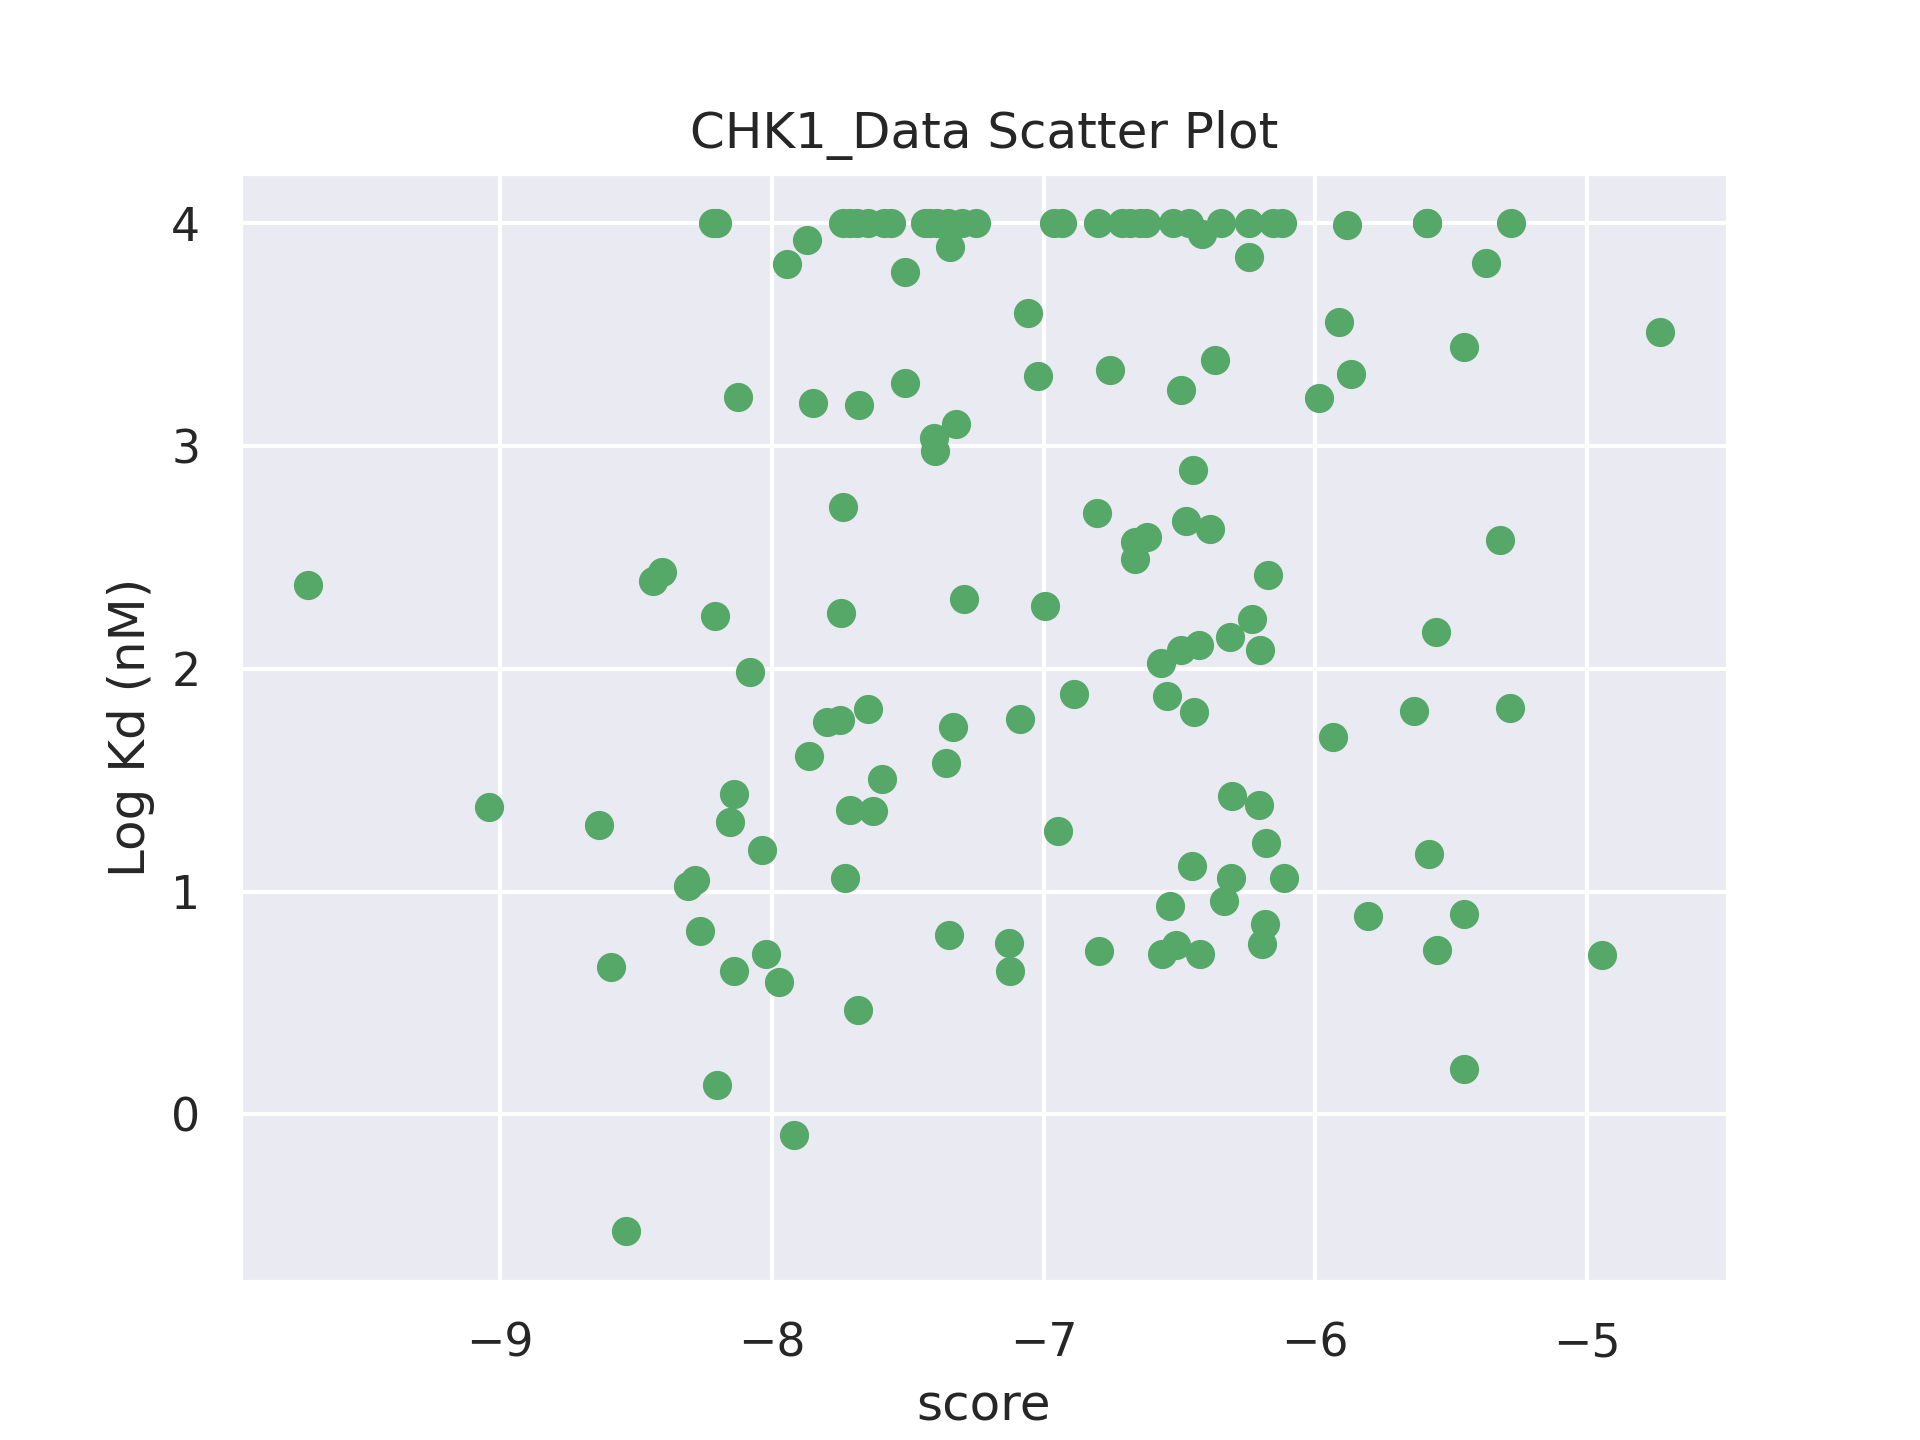
</div>

Once again the title of the scatter plot is extracted from the `CSV` file name. The x and y axes labels are extracted from the `"data_metric"` and `"exp_metric"` parameters in the configuration `JSON` above. The scatter plot shows the distribution of (docking score, experimental activity) pairs. As with before, correlation metrics are calculated and saved into a `JSON` file.

`{
  "CHK1_Data.csv": {
    "coeff_determination": 0.012665427425591846,
    "Spearman_coeff": 0.0947266781245275,
    "Kendall_coeff": 0.06257646699328888
  },
  "MCC_for_CHK1_Data.csv_(-7, 3)": -0.011353884997945918
}`

The scatter plots makes it evident that there is extremely poor correlation. This is reaffirmed quantitatively by the correlation metrics (e.g. Spearman correlation = ~0). In this situtation, the thresholds provided can be used to investigate general separation. Let's take a look at the stacked histograms generated.

<div>
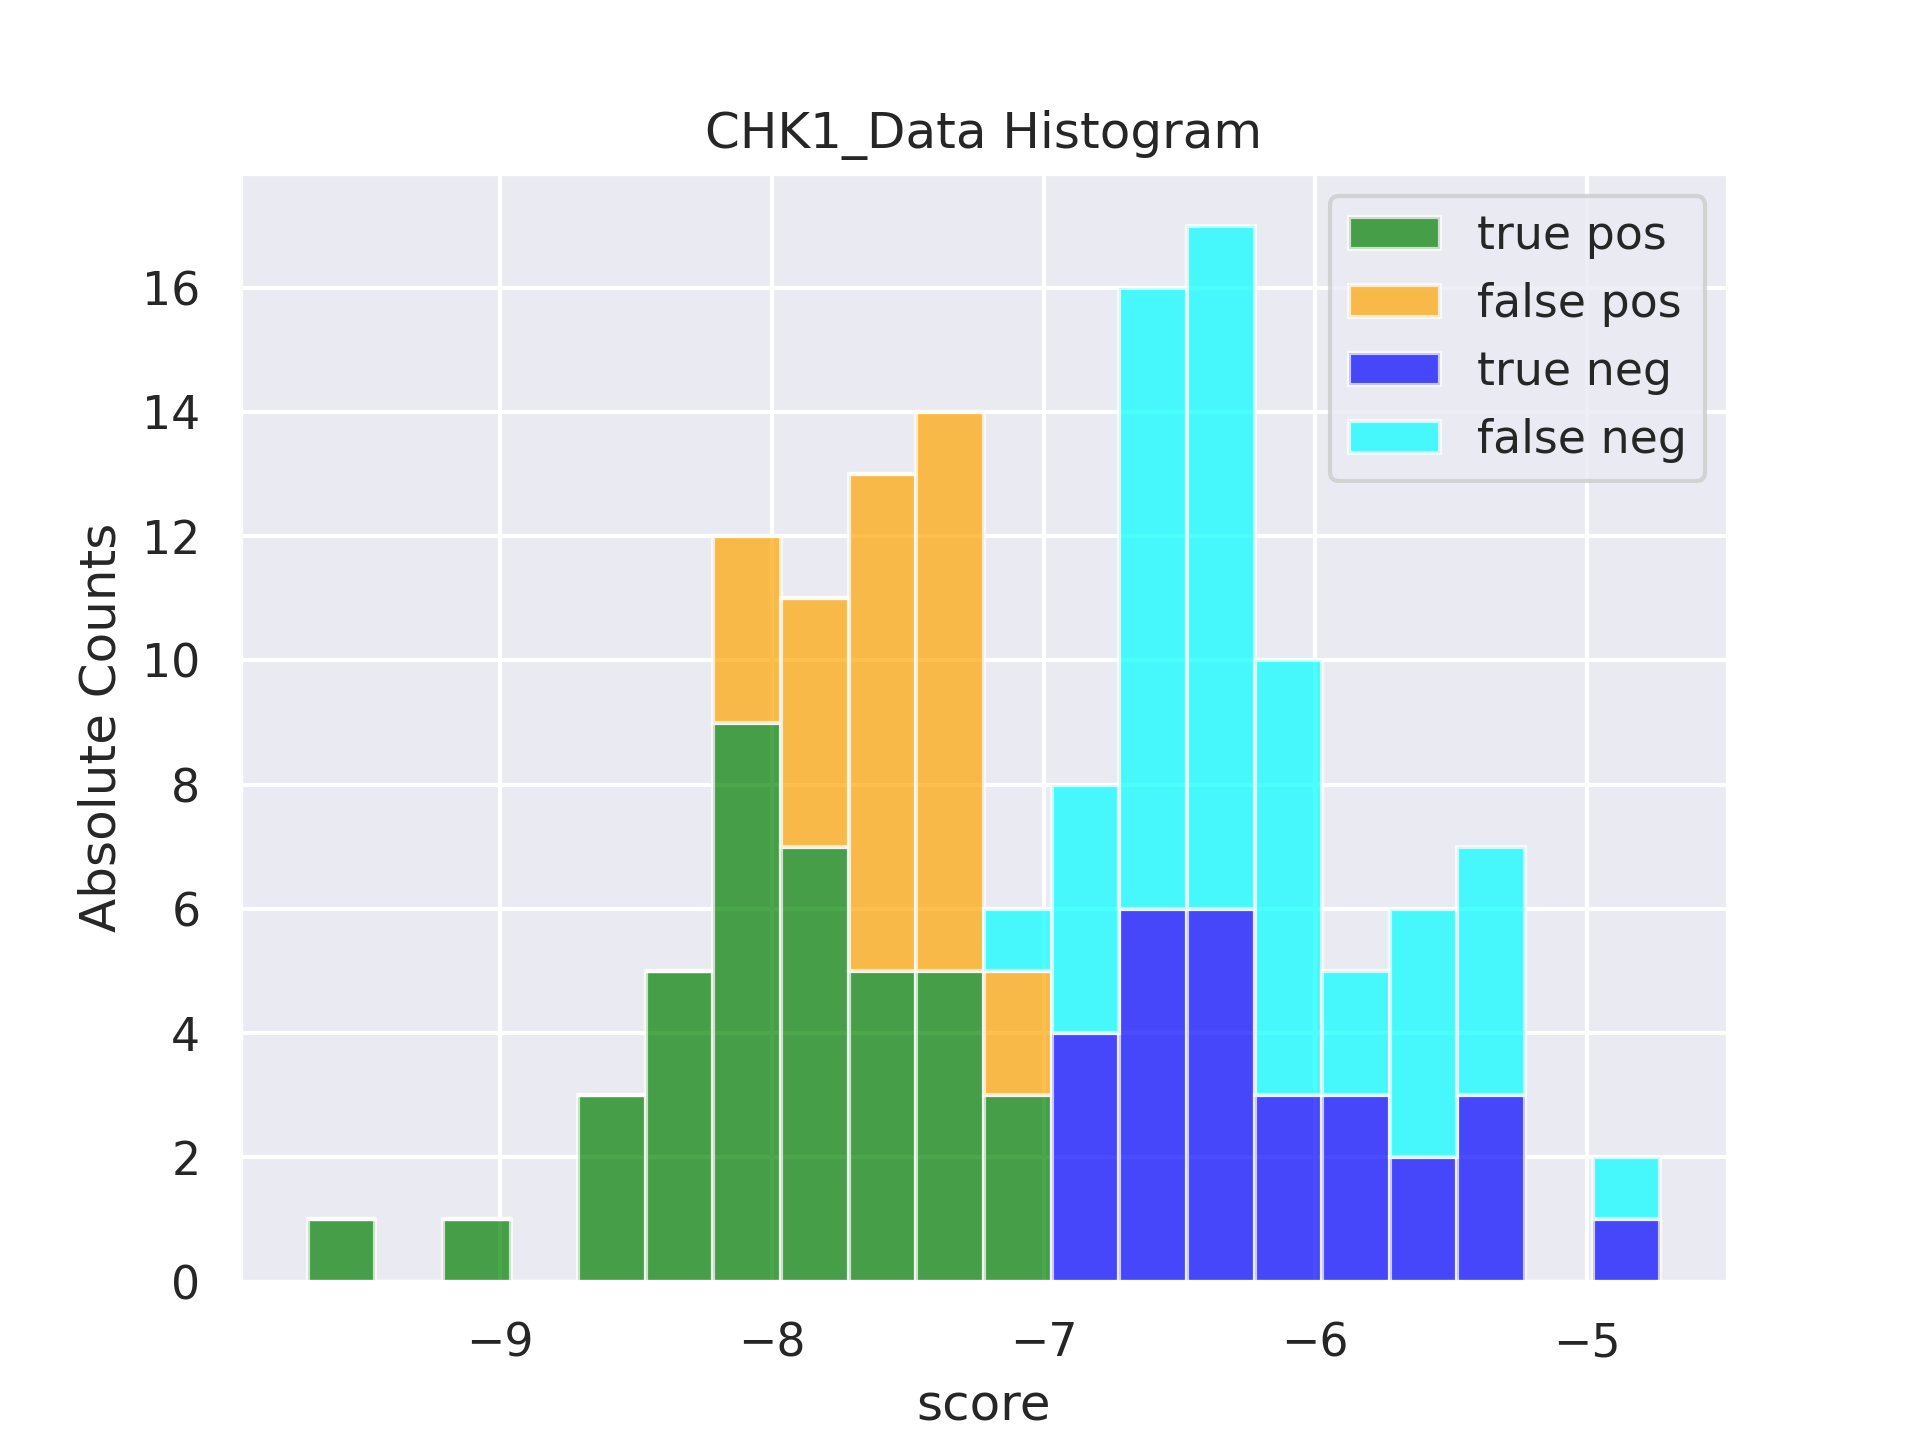
</div>

The stacked histogram shows the distribution of `true positives`, `true negatives`, `false positives`, and `false negatives` once again classified based on the user defined thresholds. A separation is now visible - this of course is only possible due to the hard cut-off values enforced by the threshold. Valuable information that can be extracted from the stacked histograms are what sort of thresholds leads to a favorable enrichment on your project. For instance, one may want to consider only docking score < -8 to maximize `true positives` and minimize `false positives`.

A pooled stacked histogram is also generated which "pools" the `true positives` and `false negatives` together and the `true negative` and `false positives` together. In essence, `pooled positives` represent all ligands that are experimentally active while `pooled negatives` represent all ligands that are experimentally inactive.

<div>
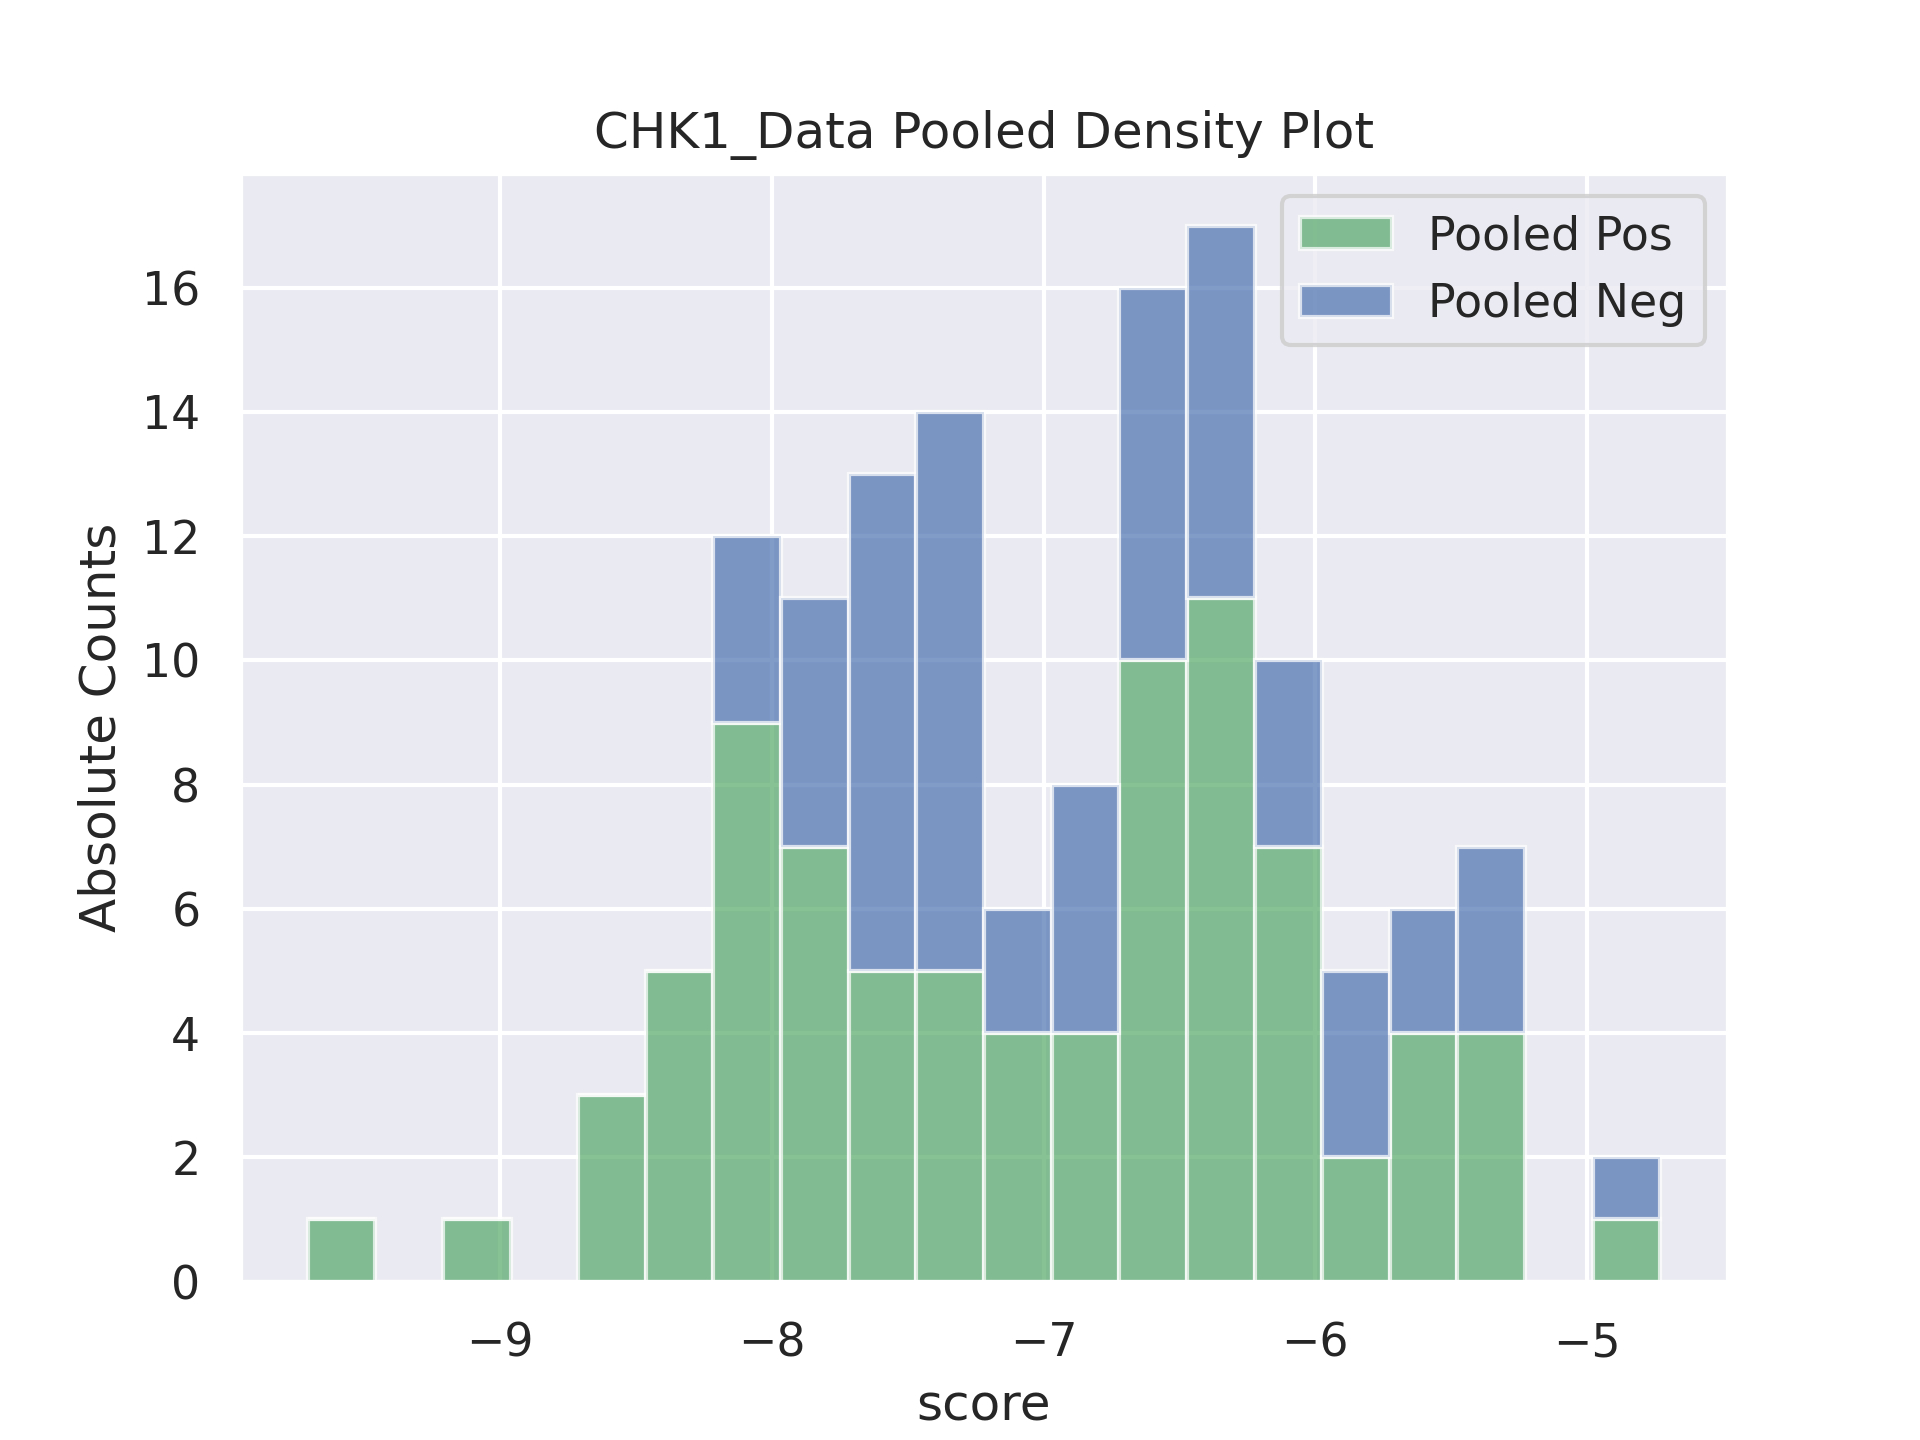
</div>

**Note:** The histograms are "stacked" meaning the `"absolute count"` for bins that feature more than 1 data classification are meant to be counted from the height visible and not from the base (e.g. for the pooled histogram at ~ -5 docking score, there is 1 "pooled positive" and 1 "pooled negative" **and not** 1 "pooled positive" and 2 "pooled negatives")

An accompanying plot to the stacked histograms is the confusion matrix.

<div>
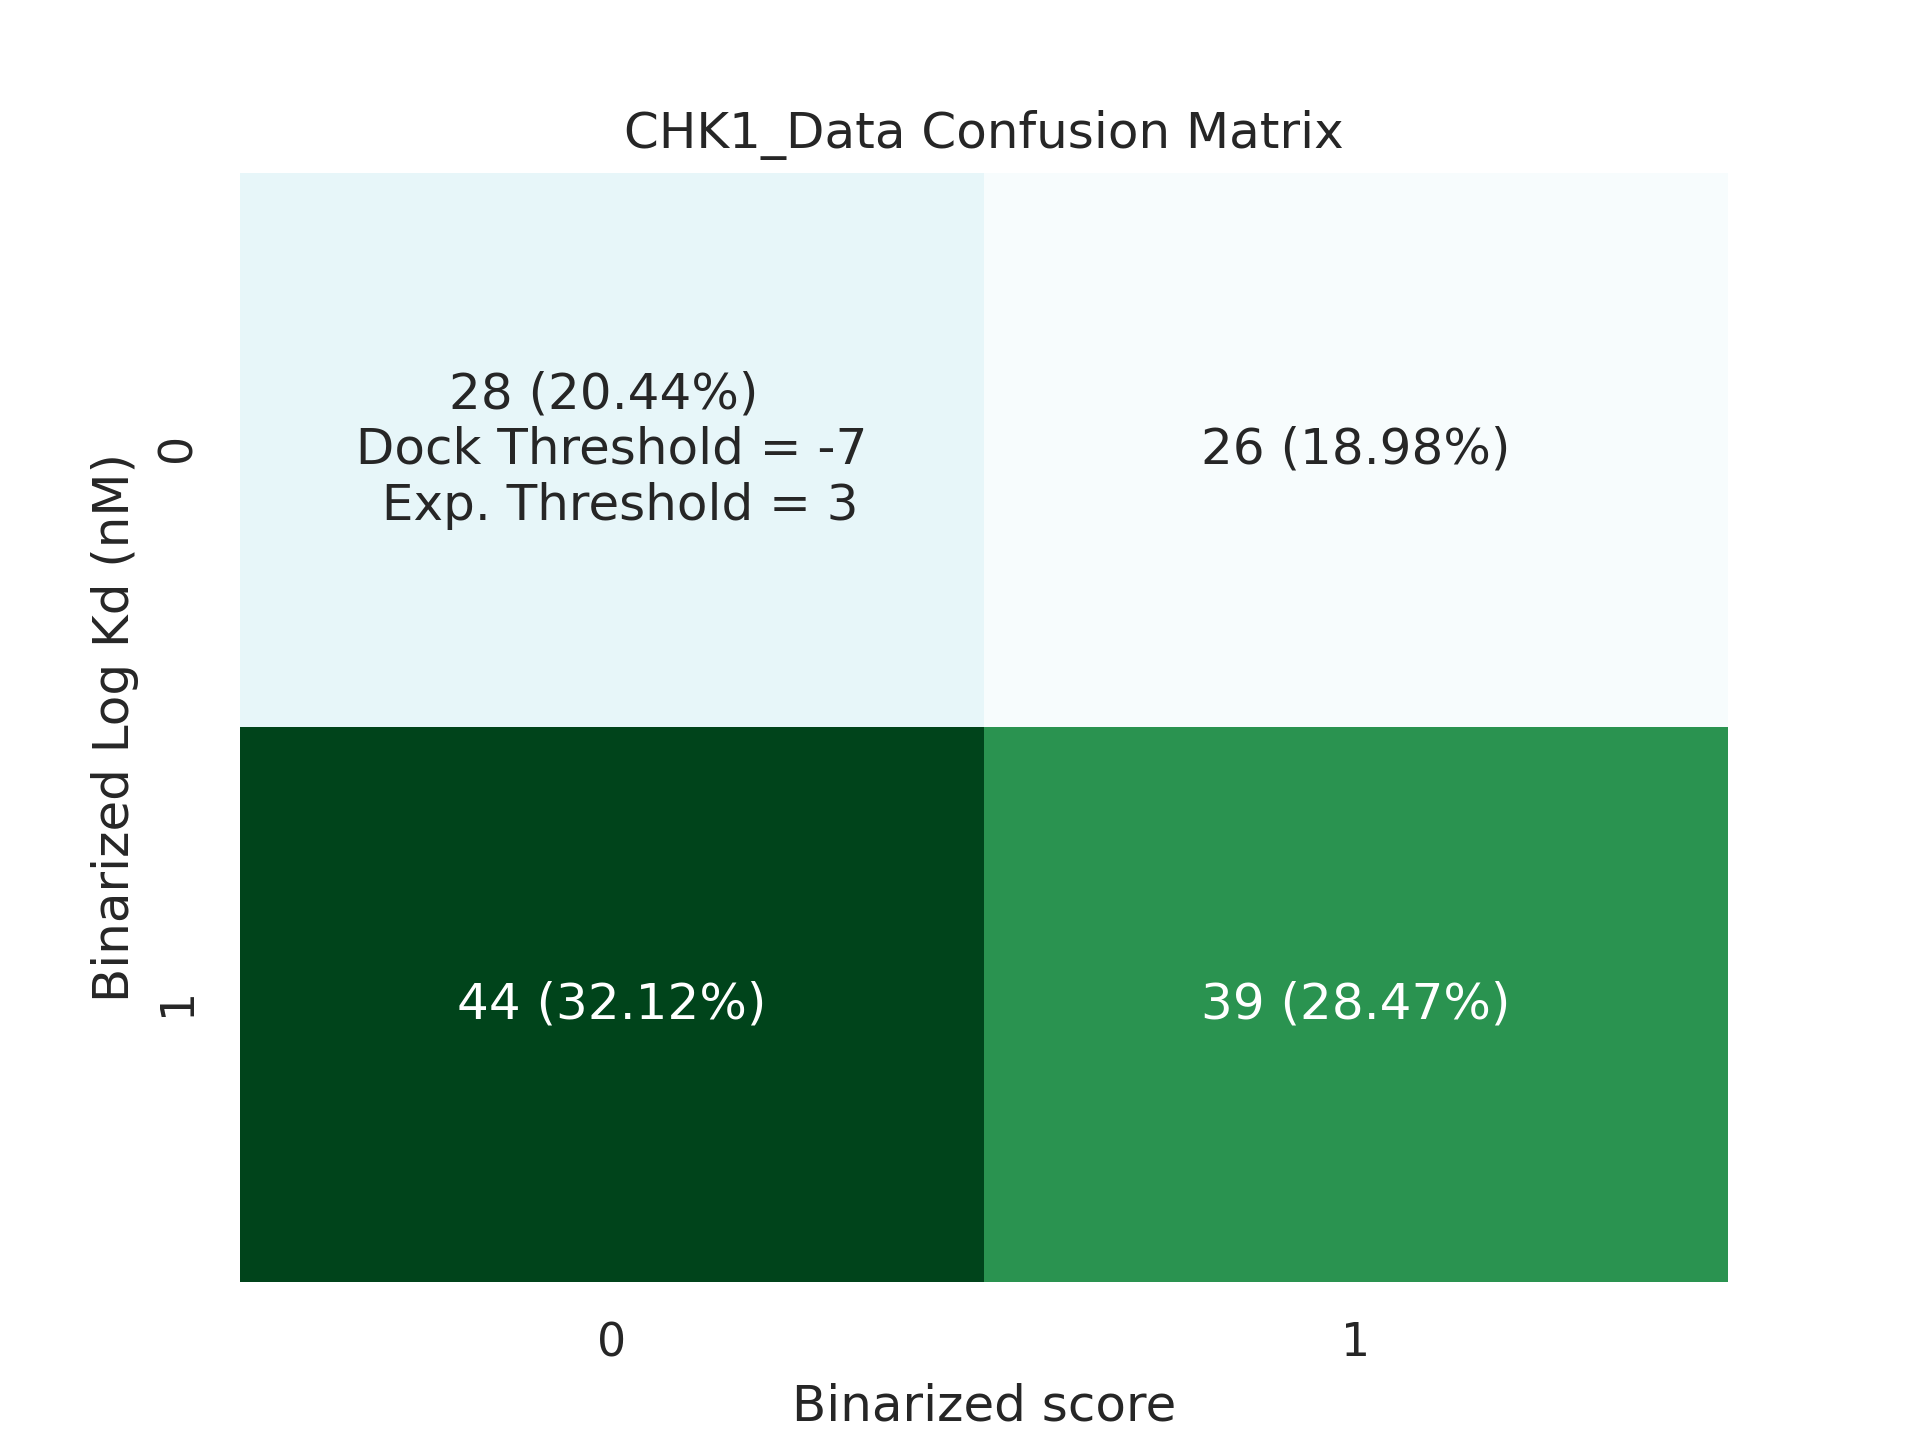
</div>


The confusion matrix features binarized docking scores and experimental activity values which are classified as "active" ("1") and "inactive" ("0") based on the user specified thresholds. For instance, the bottom right region corresponds to a binarized docking score of "1" and a binarized experimental activity value of "1" - therefore, these are considered `true positives` (docking active and experimentally active). As illustrated in the plot, there are 39 `true positives` given the specified thresholds. One new addition to the output statistics `JSON` is the Matthews Correlation Coefficient (MCC) which for our purposes can be interpreted as, "how many more/less `false positive` + `false negative` ligands are there compared to `true positive` + `true negative` ligands given the user specified thresholds?" Please see `Appendix: Analysis Metrics` for details regarding the MCC. The output correlation `JSON` is displayed below again:

`{
  "CHK1_Data.csv": {
    "coeff_determination": 0.012665427425591846,
    "Spearman_coeff": 0.0947266781245275,
    "Kendall_coeff": 0.06257646699328888
  },
  "MCC_for_CHK1_Data.csv_(-7, 3)": -0.011353884997945918
}`


The values pair in parentheses, (-7, 3) denotes that the MCC corresponds to a docking score threshold of -7 and an experimental activity threshold of 3. The MCC is best analyzed in combination with the confusion matrix. It was previously stated that the MCC can be interpreted as the proportion of `true positives` + `true negatives` (67 ligands) compared to `false positives` + `false negatives` (70 ligands). Given the specified thresholds, there are more `false positives` + `false negatives` than `true positives` + `true negatives` which is why the MCC is negative.

`Thresholds Analysis` supports batch execution to evaluate many thresholds pairs at once. Simply append threshold values to the list (without limit) and the script will run each `Thresholds Analysis` successively until the list has been iterated. Let's take a look at an example analysis configuration `JSON` with multiple thresholds.

In [24]:
# note everything is the same as the JSON above except the "data thresholds" and "exp_thresholds"
# parameters, whose values are now a list containing multiple values
batch_thresholds_json = {
  "input_docking_data": {
    "data_path": CHK1_DATA_PATH,            # path to the docking data folder
    "data_metric": "score",                 # docked ligands activity metric
    "max_data_metric_best": "False",        # denotes whether a greater docking score = greater predicted affinity
    "data_thresholds": [-7, -8]             # a list that holds the thresholds to separate active/inactive ligands based on docking score
  },
  "input_exp_data": {
    "exp_data_path": CHK1_DATA_PATH,        # path to the experimental data
    "exp_metric": "Log Kd (nM)",            # experimental data activity metric
    "max_exp_metric_best": "False",         # denotes whether a greater value = greater affinity/potency
    "exp_thresholds": [3, 3]                # a list that holds the thresholds to separate active/inactive ligands based on experimental data
  },
  "input_enrichment_data": { 
    "data_path_actives": "---",       
    "data_path_inactives": "---",   
    "actives_data_metric": "---",          
    "inactives_data_metric": "---",      
    "max_metric_best": "---"                
  },
  "plot_settings": {
    "enrichment_analysis": "False",         # denotes to generate histograms, boxplots, and pROC curves only
    "pROC_overlay": "False"                 # denotes whether to generate an overlay pROC curve only
  },
  "output": {
    "output_path": thresholds_results_dir   # desired output directory
  }
}

with open(os.path.join(output_dir, "batch_thresholds.json"), "w+") as f:
    json.dump(batch_thresholds_json, f, indent=2)

`Thresholds Analysis` takes the thresholds pair (for docking data and experimental data) based on their list position (e.g. (-7, 3) followed by (-8, 3)). Let's execute batch `Threshold Analysis`.

In [ ]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {analysis_script} -input_json {os.path.join(output_dir, "batch_thresholds.json")}

#### All the expected plots (scatter plots, confusion matrices and stacked histograms) and correlation metrics are generated for each thresholds pair. For brevity, only the new correlation metrics `JSON` is shown below

`{
  "CHK1_Data.csv": {
    "coeff_determination": 0.012665427425591846,
    "Spearman_coeff": 0.0947266781245275,
    "Kendall_coeff": 0.06257646699328888
  },
  "MCC_for_CHK1_Data.csv_(-7, 3)": -0.011353884997945918,
  "MCC_for_CHK1_Data.csv_(-8, 3)": 0.2188082683889328
}`

The MCC for the thresholds pair (-8, 3) is added to the correlation metrics `JSON`. Notice it has a positive value - based on the thresholds pair (-8, 3), there are now more `true positives` + `true negatives` than `false positives` + `false negatives`.


# Appendix: Analysis Metrics

## Enrichment Analysis

**pROC AUC**
* The propensity of the docking protocol to distinguish between actives and inactives
* A `Random` docking protocol always has a pROC AUC value of 0.434 - a docking protocol displaying enrichment **must** possess pROC AUC > 0.434

For more information (including equations), see:

**R. D. Clark, et al., J. Comput. Aided Mol. Des. 2008, 22, 141-146.**

**Enrichment Factor 5% (EF 5%)**
* The number of actives recovered in the top 5% ligands (sorted by docking scores) relative to the number of actives in the entire dataset

For more information (including equations), see:
**A. Bender, et al., J. Chem. Inf. Model. 2005, 45(5), 1369-1375.

## Correlation Analysis

**Coefficient of Determination ("R-squared" - $R^{2}$)**
* Measure of linear correlation
* Values range from [-1,1]
* Interpreted as: "How well can you predict the change in the experimental activity given a change in the docking     score via a linear function?"
* Value of 1 means the experimental activity can be perfectly predicted via a linear function given a change in docking score

**Note:** The Coefficient of Determination is probably not the best metric to use to quantify the docking score correlation with experimental activity. The reason is inherent to the interpretation of the docking score. While it is true in most cases that the docking score is *"meant"* to be interpreted as the binding affinity (e.g. `Glide` docking scores have units of -kcal/mol), it is generally not accurate. Therefore, quantifying this correlation using the magnitudes of the docking score and experimental activity is not the best representation. However, the Coefficient of Determination was included because it acts firstly as a sanity check (there should still be correlation observed) and secondly, it can be interesting to observe how well a linear relationship can capture the data (there have been internal projects where a docking protocol displayed a $R^{2}$ > 0.9)

In contrast, Spearman and Kendall Ranked Correlation measures the ranked correlation (e.g. Does the "best" docking score equate to the most potent ligand? Does the 3rd "best" docking score equate to the 3rd most potent ligand? Does the "worst" docking score equate to the least potent ligand?) 

#### Spearman and Kendall Correlation Shared Characteristics:

* Measures ranked correlation and can assess non-linear monotonic relationships

* Values range from [-1,1]

* Value of -1 interpreted as: "As the docking score gets "worse", experimental activity always increases" 
  --> This is the exact opposite of what is desired 
  
* Value of 1 interpreted as: "As the docking score gets "better", experimental activity always increases" 
  --> This would mean the docking configuration is perfect 

**Spearman Correlation ("Rho" - $\rho$)**
* Does not explicitly account for repeated values in the dataset - instead, the average ranking is taken 

For more information (including equations), see: 

**Zwillinger, D. and Kokoska, S. (2000). CRC Standard Probability and Statistics Tables and Formulae. Chapman & Hall: New York. 2000. Section 14.7**
  
**Kendall Correlation ("Tau-b" - $\tau$-b)**
* "Tau-b" is a variation of Kendall Correlation chosen because it accounts for ties in the data (Spearman does not)
* The general interpretation of Kendall Correlation is: "How much more likely is one expected to observe
  correctly ranked pairs (concordant) compared to incorrectly ranked pairs (discordant)?"
* In the case of many ties in the docking and/or experimental data, Kendall Correlation is a better metric to use than Spearman Correlation

For more information (including equations), see:

**https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html (tau_b)**

**Kendall, M. G., Biometrika 1945, 33(3), 239-251**

## Thresholds Analysis
  
**Matthews Correlation Coefficient (MCC)**
* Traditionally used to evaluate the performance of binary classifiers
* Value ranges from [-1,1]
* Interpretation for our purposes is, "how many more/less `false positive` + `false negative` ligands are there compared to `true positive` + `true negative` ligands given the user specified thresholds?" Positive value means there are more `true positive` + `true negatives` and negative value means there are more `false positive` + `false negatives`

For more information (including equations), see:

**https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html**